In [86]:
from google.colab import drive
drive.mount('/content/drive')  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
# # Using segmentation_models for image segmentation task, https://github.com/qubvel/segmentation_models
! pip install segmentation-models 

In [88]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pdb
from tensorflow import keras 
# from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout, Input, MaxPool2D , Flatten
import cv2
import imgaug.augmenters as iaa
from PIL import Image, ImageDraw
from PIL import ImagePath
from tensorflow.keras.models import Model, load_model
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import LearningRateScheduler
import random
from tqdm import tqdm
from sklearn.metrics import roc_curve,precision_recall_curve, auc , multilabel_confusion_matrix
import seaborn as sns
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0 , EfficientNetB4 , EfficientNetB7
import tensorflow as tf
from tensorflow.keras.utils import to_categorical ,Sequence
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from numpy import save ,load

In [89]:
train_images_path = '/content/drive/MyDrive/severstal-steel-defect-detection/train_images'
train_masks_path = '/content/drive/MyDrive/Colab Notebooks/Self_case_study_2/severstal-steel-defect-detection/train_masks'
train_image_names = os.listdir(train_images_path)
train_masks_npy_path = '/content/drive/MyDrive/severstal-steel-defect-detection/train_mask_npy'
train_df = pd.read_csv('/content/drive/MyDrive/severstal-steel-defect-detection/train.csv') 

##Preparing Training data set 

**Preparing the training data set by merging training image names and training csv file with defects.**

In [90]:
train_image_names = pd.DataFrame(train_image_names,
                                              columns =['ImageId'])
train_df = pd.merge(train_df,train_image_names,how = 'outer',on = ['ImageId','ImageId'])
train_df = train_df.fillna(' ')
train_df.head(5)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [91]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html
train_data = pd.pivot_table(train_df, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum,fill_value= ' ').astype(str)
del train_data[' ']
train_data = train_data.reset_index()
train_data.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']
train_data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [92]:
# 'hasDefect' column indicates if there is atleast one defect in the image
insert_column = []
for i in range(len(train_data)):
    if (train_data['Defect_1'][i]== ' ' and train_data['Defect_2'][i]== ' ' and train_data['Defect_3'][i]==' ' and train_data['Defect_4'][i]==' '):
        insert_column.append(0)
    else:
        insert_column.append(1)
train_data['hasDefect'] = insert_column

# 'hasDefect_1' column indicates if there is type 1 defect in the image
insert_column = []
for i in range(len(train_data)):
    if train_data['Defect_1'][i]==' ':
        insert_column.append(0)
    else:
        insert_column.append(1)
train_data['hasDefect_1'] = insert_column

# 'hasDefect_2' column indicates if there is type 2 defect in the image
insert_column = []
for i in range(len(train_data)):
    if train_data['Defect_2'][i]==' ':
        insert_column.append(0)
    else:
        insert_column.append(1)
train_data['hasDefect_2'] = insert_column

# 'hasDefect_3' column indicates if there is type 3 defect in the image
insert_column = []
for i in range(len(train_data)):
    if train_data['Defect_3'][i]==' ':
        insert_column.append(0)
    else:
        insert_column.append(1)
train_data['hasDefect_3'] = insert_column

# 'hasDefect_4' column indicates if there is type 4 defect in the image
insert_column = []
for i in range(len(train_data)):
    if train_data['Defect_4'][i]==' ':
        insert_column.append(0)
    else:
        insert_column.append(1)
train_data['hasDefect_4'] = insert_column

train_data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4,hasDefect,hasDefect_1,hasDefect_2,hasDefect_3,hasDefect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1,0,0,0
1,00031f466.jpg,,,,,0,0,0,0,0
2,000418bfc.jpg,,,,,0,0,0,0,0
3,000789191.jpg,,,,,0,0,0,0,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1,0,0,1,0


In [93]:
# Images with defect 1 , 2 , 3 , 4
print('There are {} images with defect 1'.format(sum(train_data['hasDefect_1'])))
print('There are {} images with defect 2'.format(sum(train_data['hasDefect_2'])))
print('There are {} images with defect 3'.format(sum(train_data['hasDefect_3'])))
print('There are {} images with defect 4'.format(sum(train_data['hasDefect_4'])))

There are 897 images with defect 1
There are 247 images with defect 2
There are 5150 images with defect 3
There are 801 images with defect 4


**minority_preference column - priority to minority label**

**Observation:** Type 2 defect is the miniority class, hence minority_preference will give first peference to type 2 defect and then type 4  and then type 1 and then type 3.

In [94]:
insert_column = []
for i in range(len(train_data)):
    if train_data['hasDefect_2'].iloc[i]==1:
        insert_column.append(2)
    elif train_data['hasDefect_4'].iloc[i]==1:
        insert_column.append(4)
    elif train_data['hasDefect_1'].iloc[i]==1:
        insert_column.append(1)
    elif train_data['hasDefect_3'].iloc[i]==1:
        insert_column.append(3)
    else:
        insert_column.append(0)
train_data['minority_preference']= insert_column
train_data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4,hasDefect,hasDefect_1,hasDefect_2,hasDefect_3,hasDefect_4,minority_preference
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1,0,0,0,1
1,00031f466.jpg,,,,,0,0,0,0,0,0
2,000418bfc.jpg,,,,,0,0,0,0,0,0
3,000789191.jpg,,,,,0,0,0,0,0,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1,0,0,1,0,3


In [95]:
#Train Test validation split 
X = train_data.copy()
X_train, X_test = train_test_split(X, test_size = 0.2, stratify = X['minority_preference'],random_state=15)
print(X_train.shape, X_test.shape)

(10054, 11) (2514, 11)


##EDA

### Distribution of steel images among defect and non defect

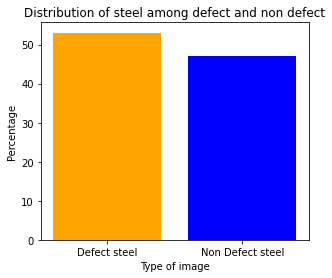

There are 10054 Total images
There are 5333 with atleast 1 defect images
There are 4721 0 defect images
53.04% of defect steel images and 46.96% of Non defect images


In [96]:
#Images with defect and non defect steel
n_total_images = X_train.shape[0]
n_defect_images = sum(X_train.hasDefect) 
n_nodefect_images = n_total_images -  n_defect_images

plt.figure(figsize = (4.8, 4)) 
plt.xlabel('Type of image')
plt.ylabel('Percentage')
plt.bar(['Defect steel', 'Non Defect steel'], [round(((n_defect_images/ n_total_images)* 100 ),2), round(((n_nodefect_images/ n_total_images)* 100 ),2)],
        color = ['orange','blue'] , width = 0.8)
plt.title('Distribution of steel among defect and non defect')
plt.show()

print('There are {} Total images'.format(n_total_images))
print('There are {} with atleast 1 defect images'.format(n_defect_images))
print('There are {} 0 defect images'.format(n_nodefect_images))
print('{}% of defect steel images and {}% of Non defect images'.format(round(((n_defect_images/ n_total_images)* 100 ),2),round(((n_nodefect_images/ n_total_images)* 100 ),2)))

**Observation** between the images with defects and no defects, the classes are almost balanced.

### Distribution of type of defect

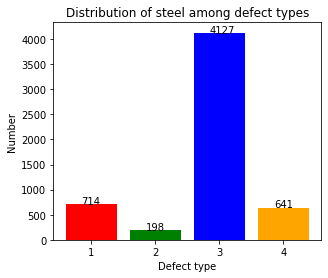

In [97]:
plt.figure(figsize = (4.8, 4)) 
plt.xlabel('Defect type')
plt.ylabel('Number')
plt.bar([1,2,3,4],X_train[['hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']].sum(axis = 0),
        color = ['red','green','blue','orange'] , width = 0.8)
xlocs, xlabs = plt.xticks()
plt.title('Distribution of steel among defect types')
for i, v in zip([1,2,3,4],X_train[['hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']].sum(axis = 0)):
    plt.text(xlocs[i] - 0.15, v + 0.5, str(v))
plt.show()

**Observation:** There are 3302 type 3 defects and just 158 type 2 defects. Hence the data is highy imbalanced.

###Distribution of number of defects in each image

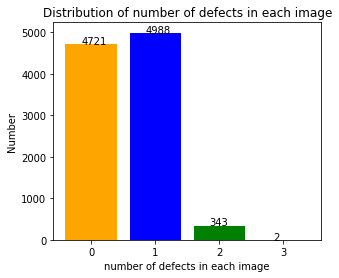

In [98]:
plt.figure(figsize = (4.8, 4)) 
plt.xlabel('number of defects in each image')
plt.ylabel('Number')
plt.bar([str(0),str(1),str(2),str(3)], X_train[['hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']].sum(axis = 1).value_counts().sort_index(),
        color = ['orange','blue','green','red'] , width = 0.8)
plt.title('Distribution of number of defects in each image')

xlocs, xlabs = plt.xticks()
for i, v in zip( [0,1,2,3], X_train[['hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']].sum(axis = 1).value_counts().sort_index()):
    plt.text(xlocs[i] - 0.15, v + 0.5, str(v))
plt.show()

**Observation** There are very few images with multi defects. 

**Run length encoding** 

Ref: https://www.youtube.com/watch?v=ssn7gjgljXQ

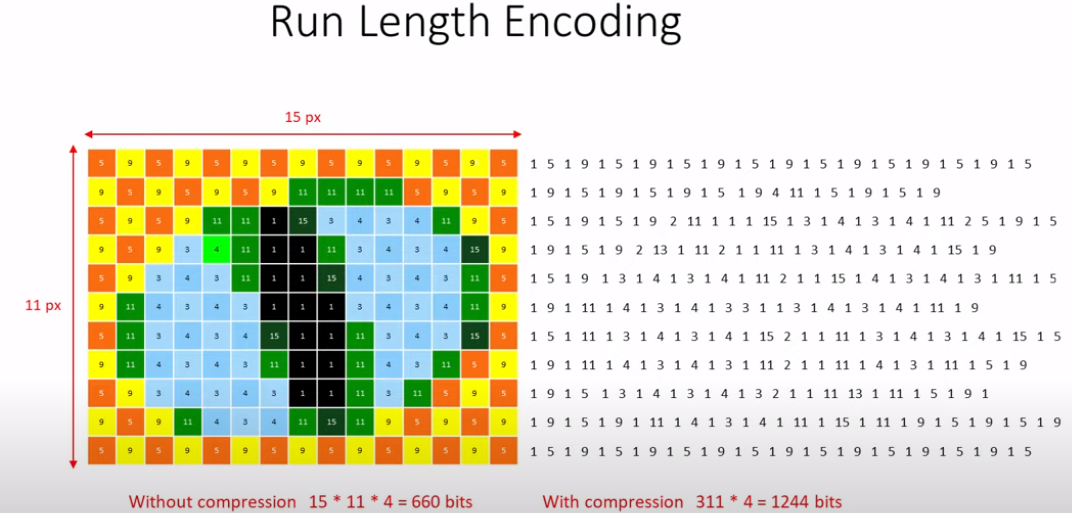

**Observation:** Above is the negative example of Run length encoding where we got extra bits after encoding.

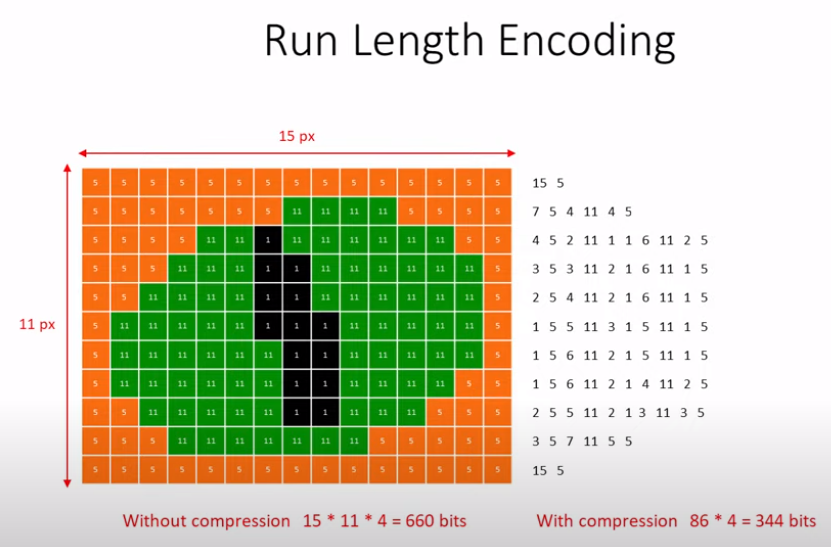

**Observation:** Works best when data contain long runs of the same value.

Sample images with no defects:


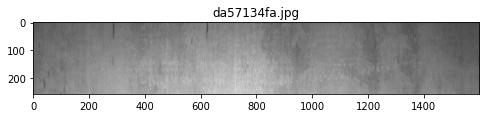

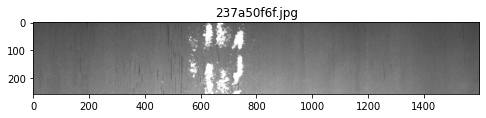

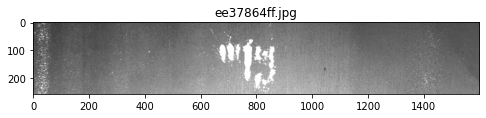

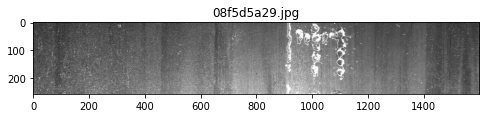

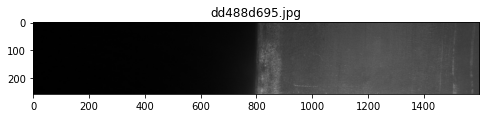

In [99]:
# 5 images having no defects
tmp = []
cnt=0
print("Sample images with no defects:")
for i in X_train['ImageId'][X_train['hasDefect']==0]:
    if cnt<5:
        fig, ax = plt.subplots(1,1,figsize=(8, 7))
        # img = Image.open(os.path.join(train_images_path,i))
        img = cv2.imread(os.path.join(train_images_path , i))
        plt.imshow(img)
        ax.set_title(i)
        plt.show()
        cnt+=1

**Observation:** Even 1st image has some defect. However, it seems, the expectation is to detect particular type of 4 defects.

In [100]:
# image_width = []
# image_height = []

# for ele in tqdm(X_train.ImageId) :
#   img = Image.open(os.path.join(train_images_path,ele)) 
#   image_width.append(img.width)
#   image_height.append(img.height)
# image_width = np.array(image_width)
# image_height = np.array(image_height)

In [101]:
# print(( image_width != 1600 ).sum())
# print(( image_height != 256 ).sum())

**Observation:** We can observe that, all the images have width as 1600 and height as 256.

**Understanding the RGB , Gray scale images and masks**
 https://www.youtube.com/watch?v=WYCvYLwIltk 

for reading an RGB image : cv2.imread( image_path , cv2.IMREAD_COLOR ) 

for reading an grayscale image : cv2.imread( image_path , cv2.IMREAD_GRAYSCALE )

for writing an image ( both RGB and GREY scale ): cv2.imread( image_path , image_matrix ) 

Lets say we have single frame with all the classes with their number correspondingly from 0 to n respectively. Then to change it to grey scale, the entire matrix need to be divided with max - min and then multiply with 255 and then the matrix can be saved as an grey scale image. 255 here means white and 0 represents black.

Whereas, for RGB, we need to encode the pixels respectively to denote the colour.


In [102]:
colourmap = [[0, 0, 0], [255, 105, 180], [ 180,255,105],[ 105, 180,255], [255, 255,105]]
classes_tocolour =   dict({0: [0, 0, 0], 1: [255, 105, 180], 2:  [180,255,105], 3:[105, 180,255], 4: [ 255, 255,105]})
classes = [0,1,2,3,4]  

In [103]:
# We need a function to convert EncodedPixels into mask
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

def rle2_1frame(mask_rle_list, shape=(1600,256)):
    '''
    mask_rle: list of strings(run-length as string formated (start length)), each for 1,2,3,4 defects 
    shape: (width,height) of array to return 
    Returns 2 D numpy array. 0 for no defect, 1 defect 1 , 2 for defect 2 , 3 for defect 3 and 4 for defect 4
    This function is specific to this competition
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)    
    for i in range(len(mask_rle_list)):
      if mask_rle_list[i] != ' ' :
        sp = mask_rle_list[i].split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (sp[0:][::2], sp[1:][::2])]
        starts -= 1
        ends = starts + lengths
        # pdb.set_trace()
        for lo, hi in zip(starts, ends):
            img[lo:hi] = i+1 
    img = img.reshape(shape).T      
    return img #256 * 1600

In [104]:
def rle_to_RGBmask(mask_rle_list, classes_tocolour ,shape=(1600,256)):
  ''' 
  This function will save the RGB masks from RLE
  '''
  img = rle2_1frame(mask_rle_list, shape=(1600,256))
  # pdb.set_trace()
  #Till here we got 256 X 1600 and now we have to convert this matrix to an RGB encoded mask
  RGB_image = []
  for outer in img :
    col = []
    for inner in outer :
      col.append(classes_tocolour.get(inner))  
    RGB_image.append(col)
  return np.array(RGB_image) #256 X 1600 X 3 

In [105]:
def RGBmask_to_width_height_classes ( rgb_mask , colourmap ):
  ''' 
  This function will convert the RGB mask to width X height X classes
  '''
  output_mask = []
  for i , color in enumerate(colourmap): 
    cmap = np.all(np.equal(rgb_mask , color ), axis = -1)
    cmap.astype(int)  
    output_mask.append(cmap)
  output_mask = np.stack(output_mask , axis = -1)
  output_mask = output_mask.astype(np.uint8)
  return output_mask #output will have five channels. any pixel will have 1 in any one of the 5 channels 

In [106]:
def width_height_classes_toRGB(img,classes_tocolour):
  ''' Given an widthXheightXclasses we need to convert into an RGB image 256X1600X5  to 256 X 1600 X 3'''
  img = np.argmax(img,axis= -1) #256 X 1600
  RGB_image = []
  for outer in img :
    col = []
    for inner in outer :
      col.append(classes_tocolour.get(inner))  
    RGB_image.append(col)
  return np.array(RGB_image) #256 X 1600 X 3 

In [107]:
def one_frame_rgb(img,classes_tocolour):
  RGB_image = []
  for outer in img :
    col = []
    for inner in outer :
      col.append(classes_tocolour.get(inner))  
    RGB_image.append(col)
  return np.array(RGB_image) #256 X 1600 X 3 

In [108]:
# # saving the widthXheightXchannels for all the train images
# train_numpy_masks = []
# for index, row in X_train.iterrows():
#   mask_rle_list = [row.Defect_1,row.Defect_2,row.Defect_3,row.Defect_4] 
#   rgb_mask = rle_to_RGBmask(mask_rle_list, classes_tocolour, shape=(1600, 256))
#   image_mask = RGBmask_to_width_height_classes(rgb_mask, colourmap)  #256 X 1600 X 5 
#   mask_name = row.ImageId.split('.')[0]
#   mask_name = mask_name + '.npy'
#   mask_name = os.path.join(train_masks_npy_path,mask_name)
#   train_numpy_masks.append(mask_name)
#   # save to npy file
#   save(mask_name,image_mask) 

# test_numpy_masks = []
# for index, row in X_test.iterrows():
#   mask_rle_list = [row.Defect_1,row.Defect_2,row.Defect_3,row.Defect_4] 
#   rgb_mask = rle_to_RGBmask(mask_rle_list, classes_tocolour, shape=(1600, 256))
#   image_mask = RGBmask_to_width_height_classes(rgb_mask, colourmap)  #256 X 1600 X 5 
#   mask_name = row.ImageId.split('.')[0]
#   mask_name = mask_name + '.npy'
#   mask_name = os.path.join(train_masks_npy_path,mask_name)
#   test_numpy_masks.append(mask_name)
#   # save to npy file
#   save(mask_name,image_mask) 
# save('/content/drive/MyDrive/severstal-steel-defect-detection/train_numpy_masks.npy',np.array(train_numpy_masks))
# save('/content/drive/MyDrive/severstal-steel-defect-detection/test_numpy_masks.npy',np.array(test_numpy_masks))
# X_train['train_numpy_masks'] = train_numpy_masks
# X_test['test_numpy_masks'] = test_numpy_masks 

In [ ]:
X_train['numpy_masks'] = load('/content/drive/MyDrive/severstal-steel-defect-detection/train_numpy_masks.npy')
X_test['numpy_masks'] = load('/content/drive/MyDrive/severstal-steel-defect-detection/test_numpy_masks.npy')

Images and masks with out any defects
--------------------------------------------------------------------------------


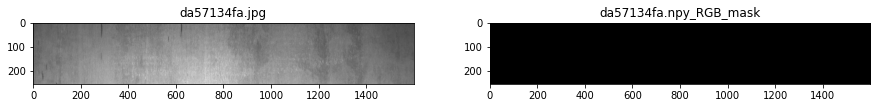

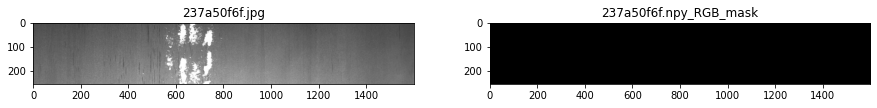

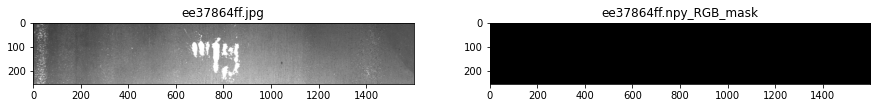

In [110]:
# Visualization: Sample images having defect
print('Images and masks with out any defects')
cnt = 0
for i in X_train['ImageId'][X_train.hasDefect == 0 ].values :
  if cnt < 3:
    fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 10))
    img = cv2.imread(os.path.join(train_images_path , i))
    ax1.imshow(img)
    ax1.set_title(i) 
    
    file_name = (i).split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X5
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    # img = cv2.imread(os.path.join(train_images_path , i))
    ax2.imshow(original_mask)
    ax2.set_title(file_name + '_RGB_mask')    
    # plt.show()
    cnt+=1 
  else :
    break
print('-'*80)   

Images and masks with type1 defects
--------------------------------------------------------------------------------


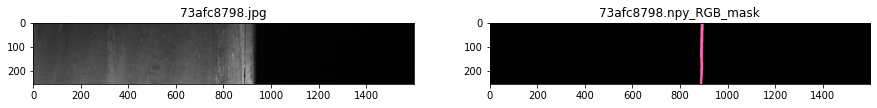

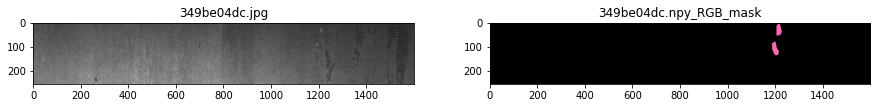

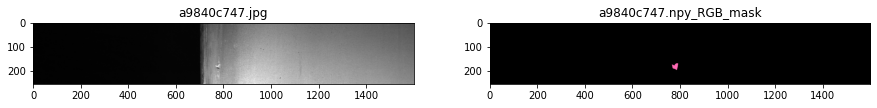

In [111]:
# Visualization: Sample images having defect
print('Images and masks with type1 defects')
cnt = 0
for i in X_train['ImageId'][(X_train.hasDefect_1 == 1) & (X_train.hasDefect_2 == 0) & (X_train.hasDefect_3 == 0) & (X_train.hasDefect_4 == 0)].values :
  if cnt < 3:
    fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 10))
    img = cv2.imread(os.path.join(train_images_path , i))
    ax1.imshow(img)
    ax1.set_title(i) 
    
    file_name = (i).split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X5
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    # img = cv2.imread(os.path.join(train_images_path , i))
    ax2.imshow(original_mask)
    ax2.set_title(file_name + '_RGB_mask')    
    # plt.show()
    cnt+=1 
  else :
    break
print('-'*80) 

Images and masks with type2 defects
--------------------------------------------------------------------------------


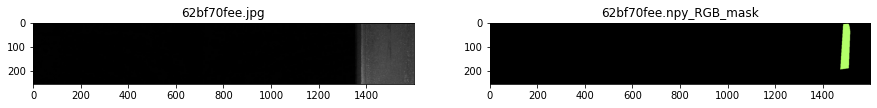

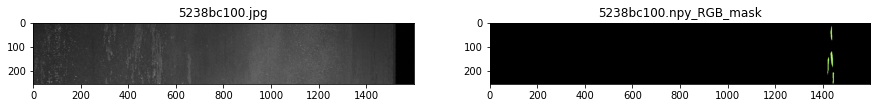

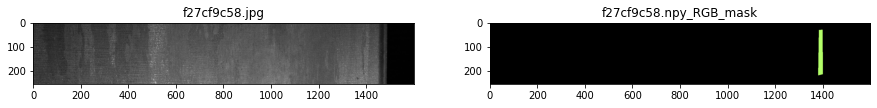

In [112]:
# Visualization: Sample images having defect
print('Images and masks with type2 defects')
cnt = 0
for i in X_train['ImageId'][(X_train.hasDefect_1 == 0) & (X_train.hasDefect_2 == 1) & (X_train.hasDefect_3 == 0) & (X_train.hasDefect_4 == 0)].values :
  if cnt < 3:
    fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 10))
    img = cv2.imread(os.path.join(train_images_path , i))
    ax1.imshow(img)
    ax1.set_title(i) 
    
    file_name = (i).split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X5
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    # img = cv2.imread(os.path.join(train_images_path , i))
    ax2.imshow(original_mask)
    ax2.set_title(file_name + '_RGB_mask')    
    # plt.show()
    cnt+=1 
  else :
    break
print('-'*80) 

Images and masks with type3 defects
--------------------------------------------------------------------------------


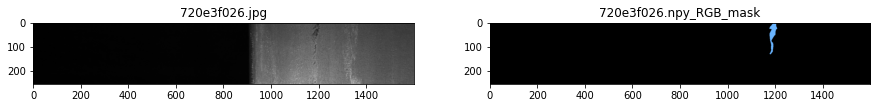

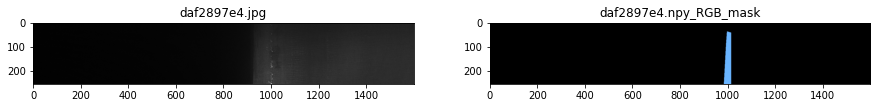

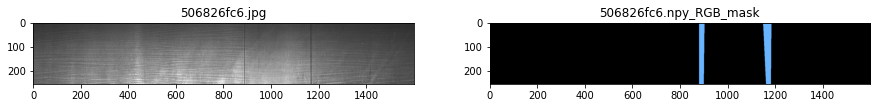

In [113]:
# Visualization: Sample images having defect
print('Images and masks with type3 defects')
cnt = 0
for i in X_train['ImageId'][(X_train.hasDefect_1 == 0) & (X_train.hasDefect_2 == 0) & (X_train.hasDefect_3 == 1) & (X_train.hasDefect_4 == 0)].values :
  if cnt < 3:
    fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 10))
    img = cv2.imread(os.path.join(train_images_path , i))
    ax1.imshow(img)
    ax1.set_title(i) 
    
    file_name = (i).split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X5
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    # img = cv2.imread(os.path.join(train_images_path , i))
    ax2.imshow(original_mask)
    ax2.set_title(file_name + '_RGB_mask')    
    # plt.show()
    cnt+=1 
  else :
    break
print('-'*80) 

Images and masks with type3 defects
--------------------------------------------------------------------------------


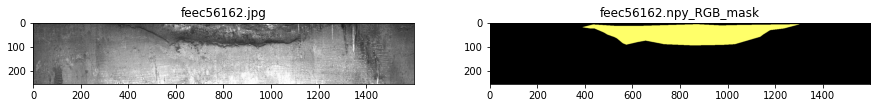

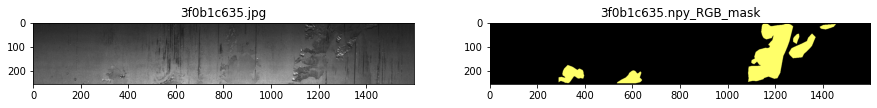

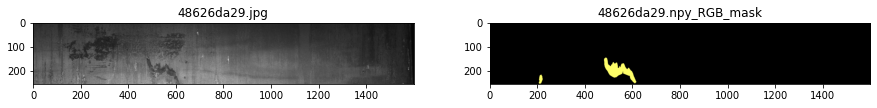

In [114]:
# Visualization: Sample images having defect
print('Images and masks with type3 defects')
cnt = 0
for i in X_train['ImageId'][(X_train.hasDefect_1 == 0) & (X_train.hasDefect_2 == 0) & (X_train.hasDefect_3 == 0) & (X_train.hasDefect_4 == 1)].values :
  if cnt < 3:
    fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 10))
    img = cv2.imread(os.path.join(train_images_path , i))
    ax1.imshow(img)
    ax1.set_title(i) 
    
    file_name = (i).split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X5
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    # img = cv2.imread(os.path.join(train_images_path , i))
    ax2.imshow(original_mask)
    ax2.set_title(file_name + '_RGB_mask')    
    # plt.show()
    cnt+=1 
  else :
    break
print('-'*80) 

**Observation:** Type 4 defects are mostly with welding sediments 

**Multi defect images** 

Images and masks with defect 1, 2 and 3


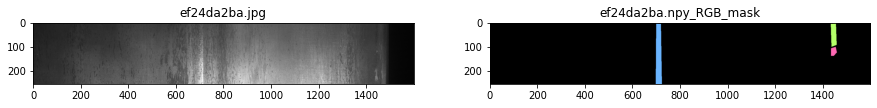

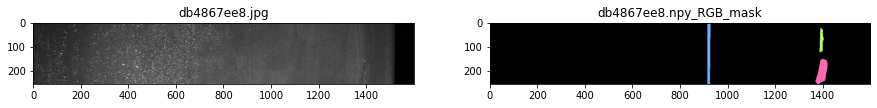

In [115]:
print('Images and masks with defect 1, 2 and 3')
cnt = 0
for i in X_train['ImageId'][(X_train.hasDefect_1 == 1) & (X_train.hasDefect_2 == 1) & (X_train.hasDefect_3 == 1) & (X_train.hasDefect_4 == 0)].values :
  if cnt < 3:
    fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 10))
    img = cv2.imread(os.path.join(train_images_path , i))
    ax1.imshow(img)
    ax1.set_title(i) 
    
    file_name = (i).split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X5
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    # img = cv2.imread(os.path.join(train_images_path , i))
    ax2.imshow(original_mask)
    ax2.set_title(file_name + '_RGB_mask')    
    plt.show()
    cnt+=1 
  else :
    break

Images and masks with defect 3 and 4 


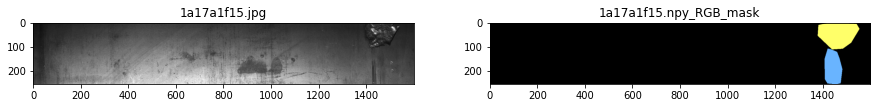

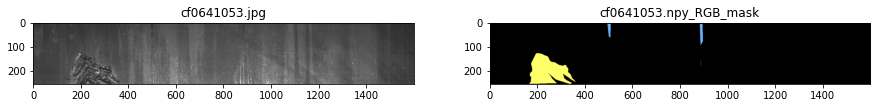

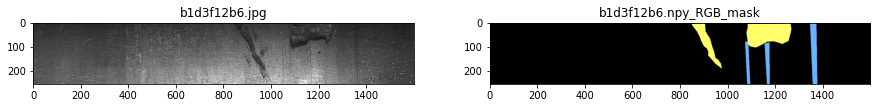

In [116]:
print('Images and masks with defect 3 and 4 ')
cnt = 0
for i in X_train['ImageId'][(X_train.hasDefect_1 == 0) & (X_train.hasDefect_2 == 0) & (X_train.hasDefect_3 == 1) & (X_train.hasDefect_4 == 1)].values :
  if cnt < 3:
    fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 10))
    img = cv2.imread(os.path.join(train_images_path , i))
    ax1.imshow(img)
    ax1.set_title(i) 
    
    file_name = (i).split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X5
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    # img = cv2.imread(os.path.join(train_images_path , i))
    ax2.imshow(original_mask)
    ax2.set_title(file_name + '_RGB_mask')    
    plt.show()
    cnt+=1 
  else :
    break

In [117]:
# # Metrics
# # For image segmentation
# # COMPETITION METRIC
# # https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate
# def dice_coef(y_true, y_pred, smooth=K.epsilon()):
#     '''
#     This function returns dice coefficient of similarity between y_true and y_pred
#     Dice coefficient is also referred to as F1_score, but we will use this name for image segmentation models
#     For example, 
#     let an instance on y_true and y_pred be [[1,1],[0,1]] and [[1,0],[0,1]]
#     this metric first converts the above into [1,1,0,1] abd [1,0,0,1],
#     then intersection is calculated as 1*1 + 1*0 + 0*1 + 1*1 = 2 and sum(y_true)+sum(y_pred)= 3+2 = 5
#     this returns the value (2.* 2 + 10e-7)/(3 + 2 + 10e-7) ~ 0.8    
#     '''
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# # Custom metrics, https://stackoverflow.com/questions/59196793/why-are-my-metrics-of-my-cnn-not-changing-with-each-epoch
# # For clasification
# def recall_m(y_true, y_pred):
#     '''
#     This function returns recall_score between y_true and y_pred
#     This function is ported as a metric to the Neural Network Models
#     Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
#     as input and returns recall score of the batch
#     '''
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # calculates number of true positives
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))      # calculates number of actual positives
#     recall = true_positives / (possible_positives + K.epsilon())   # K.epsilon takes care of non-zero divisions
#     return recall

# def precision_m(y_true, y_pred):
#     '''
#     This function returns precison_score between y_true and y_pred
#     This function is ported as a metric to the Neural Network Models
#     Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
#     as input and returns prediction score of the batch
#     '''
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # calculates number of true positives
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))      # calculates number of predicted positives   
#     precision = true_positives /(predicted_positives + K.epsilon()) # K.epsilon takes care of non-zero divisions
#     return precision
    
# def f1_score_m(y_true, y_pred):
#     '''
#     This function returns f1_score between y_true and y_pred
#     This 
#     This function is ported as a metric to the Neural Network Models
#     Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
#     as input and returns f1 score of the batch
#     '''
#     precision = precision_m(y_true, y_pred)  # calls precision metric and takes the score of precision of the batch
#     recall = recall_m(y_true, y_pred)        # calls recall metric and takes the score of precision of the batch
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

# dependencies = {
#     'recall_m':recall_m,
#     'precision_m':precision_m,
#     'dice_coef':dice_coef,
#     'f1_score_m':f1_score_m,
#     'dice_loss':sm.losses.dice_loss
# }

## Model Design 

**We have to use custom Unet with Efficient net as encoder for multi label defect detection and use the encoder along with cusotm dense and dropout layers to detect the binary classification of detecting the 'hasdefect' and 'nodefect' images.**

https://www.youtube.com/watch?v=2uIq1FvVfp8 

### **Utility Functions**

In [118]:
# updatable plot
# a minimal example (sort of)
from IPython.display import clear_output
from prettytable import PrettyTable
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.Iou_score =[]
        self.val_iou_score = []
        plt.figure(figsize=(35, 7))
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.Iou_score.append(logs.get('iou_score'))
        self.val_iou_score.append(logs.get('val_iou_score'))
        self.i += 1
        clear_output(wait=True)
        x = PrettyTable()
        x.add_column("Epoch",self.x)
        x.add_column("Loss",self.losses)
        x.add_column("Val_Loss",self.val_losses)
        x.add_column("Iou Scrore",self.Iou_score)
        x.add_column("Val_Iou Scrore",self.val_iou_score)
        print(x)
        plt.subplot(121)
        plt.plot(self.x, self.Iou_score, label="Iou_Score")
        plt.plot(self.x, self.val_iou_score, label="val_Iou_Score")        
        plt.title('Model iou_score')
        plt.ylabel('iou_score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        

        plt.subplot(122)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()      
plot_losses = PlotLosses()

In [119]:
class Plot_Binary_Losses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy =[]
        self.val_accuracy = []
        plt.figure(figsize=(35, 7))
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        self.i += 1
        clear_output(wait=True)
        x = PrettyTable()
        x.add_column("Epoch",self.x)
        x.add_column("Loss",self.losses)
        x.add_column("Val_Loss",self.val_losses)
        x.add_column("accuracy",self.accuracy)
        x.add_column("Val_accuracy",self.val_accuracy)
        print(x)
        plt.subplot(121)
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.plot(self.x, self.val_accuracy, label="val_accuracy")        
        plt.title('Model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        

        plt.subplot(122)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()      
plot_binary_losses = Plot_Binary_Losses()

In [148]:
def plot_confusion_matrix(test_y,predict_y,target_names): 
    '''For the predicted and actual y, we will print the confusion matrix'''
    CM = multilabel_confusion_matrix(test_y, predict_y)  # 5 2X2
    # pdb.set_trace()
    for i in range(len(target_names)):
      C = CM[i,:,:]
      print("Confusion , Precision and recall matrices for {}".format(target_names[i]))
      R =(((C.T)/(C.sum(axis=1))).T)
      #divid each element of the confusion matrix with the sum of elements in that column
    
      P =(C/C.sum(axis=0))
      #divid each element of the confusion matrix with the sum of elements in that row

      plt.figure(figsize=(20,2))
    
      labels = [0,1]
      cmap=sns.light_palette("blue")
      plt.subplot(1, 3, 1)
      sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
      plt.xlabel('Predicted Class')
      plt.ylabel('Original Class')
      plt.title("Confusion matrix")
    
      plt.subplot(1, 3, 2)
      sns.heatmap(P, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
      plt.xlabel('Predicted Class')
      plt.ylabel('Original Class')
      plt.title("Precision matrix")
      
      plt.subplot(1, 3, 3)
      sns.heatmap(R, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
      plt.xlabel('Predicted Class')
      plt.ylabel('Original Class')
      plt.title("Recall matrix")
      plt.show() 

In [122]:
X_train_binary = X_train[['ImageId','hasDefect']]
X_test_binary = X_train[['ImageId','hasDefect']] 

### **Multilabel Classification model with efficient net B0 as back bone**

**Reference links**
https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d 

https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture/blob/main/TensorFlow/efficientnetb0_unet.py

https://www.youtube.com/watch?v=2uIq1FvVfp8


In [ ]:
class Unet_efficnetB0 :
  def __init__(self,input_shape,classes):
    tf.keras.backend.clear_session()
    self.input_shape = input_shape
    self.classes = classes
    self.inputs = Input(input_shape)
    self.encoder = EfficientNetB0(include_top=False, weights='imagenet', input_tensor= self.inputs)

  def conv_block(self,inputs,num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

  def decoder_block(self,inputs,skip, num_filters):
      x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
      x = Concatenate()([x, skip])
      x = self.conv_block(x, num_filters)
      return x

  def build_efficient_unet(self):
    
    s1 = self.encoder.get_layer("input_1").output  #skip connection 256X1600 

    s2 = self.encoder.get_layer("block2a_expand_activation").output  #skip connection 128X800

    s3 = self.encoder.get_layer("block3a_expand_activation").output  #skip connection 64X400

    s4 = self.encoder.get_layer("block4a_expand_activation").output  #skip connection 32X200

    """ Bottle neck"""

    b1 = self.encoder.get_layer("block6a_expand_activation").output  # 16X100

    """decoder block"""
    d1 = self.decoder_block(b1,s4,512) #32 X 200 X 512 

    d2 = self.decoder_block(d1,s3,256) #64 X 400 X 256

    d3 = self.decoder_block(d2,s2,128) #128 X 800 X 128
  
    d4 = self.decoder_block(d3,s1,64) #256 X 1600 X 128

    """Output"""
    outputs = Conv2D(self.classes,1,padding = "same" , activation= "softmax")(d4) 
    
    unet_model = Model(self.inputs , outputs, name = "EfficientNetB0_UNET") 

    return  unet_model
if __name__ == "__main__" :
  input_shape  = (256,1600,3)
  ueff = Unet_efficnetB0(input_shape = input_shape,classes = 5 )
  unet_model = ueff.build_efficient_unet()
  unet_model.summary()
  # model.get_layer("block6a_expand_activation") #16 X 100 X   

16719872/16705208 [==============================] - 0s 0us/step
Model: "EfficientNetB0_UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1600, 3 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 1600, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 1600, 3) 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 1601, 3) 0           normalization[0][0]              
_______________

In [ ]:
# import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))

In [ ]:
ImageId= [ os.path.join(train_images_path,row.ImageId) for index,row in X_train.iterrows() ]
# MaskId= [ os.path.join(train_masks_path,row.ImageId) for index,row in X_train.iterrows() ]
X_train['ImageId'] = ImageId
# X_train['MaskId'] = MaskId

ImageId= [ os.path.join(train_images_path,row.ImageId) for index,row in X_test.iterrows() ]
# MaskId= [ os.path.join(train_masks_path,row.ImageId) for index,row in X_test.iterrows() ]
X_test['ImageId'] = ImageId
# X_test['MaskId'] = MaskId

In [ ]:
class Dataset:
    def __init__(self, data_df, preparation_for):
        
        self.images_fps   = data_df['ImageId'].values
        self.mask_fps     = data_df['numpy_masks'].values
        #preparation for = train or test
        self.preparation_for = preparation_for
        self.w = 256
        self.h = 1600
    
    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = load(self.mask_fps[i])

        if self.preparation_for == 'train':
          a = np.random.uniform()
          if a<0.2:
              image = aug2.augment_image(image)
              image_mask = aug2.augment_image(image_mask)
          elif a<0.4:
              image = aug3.augment_image(image)
              image_mask = aug3.augment_image(image_mask)
          elif a<0.6:
              image = aug4.augment_image(image)
              image_mask = aug4.augment_image(image_mask)
          elif a<0.8:
              image = aug5.augment_image(image)
              image_mask = image_mask 
        image = image.astype('float32')        
        image_mask = image_mask.astype('float32')                
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lrate = LearningRateScheduler(scheduler)  

es = tf.keras.callbacks.EarlyStopping( monitor='val_iou_score', patience= 10 , mode = 'max')

In [ ]:
callbacks = [ tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_iou_score') ,
                                       plot_losses ,lrate,es ]

In [ ]:
# import keras
# Dataset for train images
train_dataset = Dataset(X_train, 'train')
test_dataset  = Dataset(X_test, 'test')

BATCH_SIZE= 6
train_dataloader = Dataloder(train_dataset, batch_size= BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size= BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
print(test_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)
print(test_dataloader[0][1].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE,256 , 1600, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 1600, 5)

(6, 256, 1600, 3)
(6, 256, 1600, 3)
(6, 256, 1600, 5)
(6, 256, 1600, 5)


#### Repeatition code when collab disconnects

In [ ]:
unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5') 

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.7029429078102112 | 0.7085553407669067 |  0.283279150724411  |  0.2802934944629669 |
|   1   | 0.7066059708595276 | 0.7050669193267822 |  0.2816113531589508 |  0.2809031903743744 |
|   2   | 0.6993756294250488 | 0.707130491733551  |  0.2859666049480438 | 0.28209900856018066 |
|   3   | 0.7069183588027954 | 0.7037721872329712 |  0.2823546826839447 | 0.28445950150489807 |
|   4   | 0.6991769075393677 | 0.7016794085502625 | 0.28795769810676575 | 0.28435128927230835 |
|   5   | 0.7034180164337158 | 0.7015330195426941 | 0.28430303931236267 |  0.2852267920970917 |
|   6   | 0.6943646669387817 | 0.7049307227134705 | 0.28959959745407104 |  0.2825982868671417 |
|   7   | 0.694154679775238  | 0.7067508

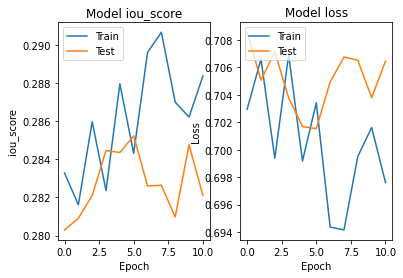

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=40,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

#### Repeatition code when collab disconnects

In [ ]:
unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5') 

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.794965922832489  | 0.7662355899810791 |  0.2221813052892685 |  0.2451537847518921 |
|   1   | 0.7465913891792297 | 0.7368069887161255 |  0.2525967061519623 |  0.2706071734428406 |
|   2   | 0.7354286313056946 | 0.7454432249069214 | 0.26033371686935425 |  0.2566048502922058 |
|   3   | 0.7216862440109253 | 0.7255983352661133 |  0.2695554494857788 |  0.2700727581977844 |
|   4   |  0.71040278673172  | 0.6934396624565125 |  0.2790239453315735 | 0.29079723358154297 |
|   5   | 0.7074854969978333 | 0.7124122977256775 | 0.28305870294570923 |  0.2820645272731781 |
|   6   | 0.7086407542228699 | 0.6989173293113708 |  0.2816876471042633 | 0.29074612259864807 |
|   7   | 0.7005836963653564 | 0.7275871

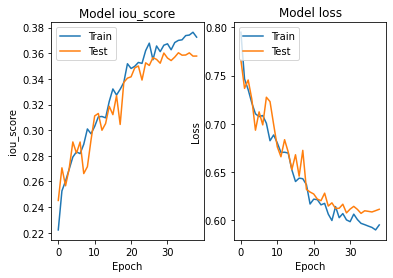

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=40,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

**Observation:** Above traininig process, the improvement in the iou score is still active but the rate of improvement is less. Hence, we will continue the traininng for another 500 epochs.

#### training continution 

In [ ]:
unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5') 

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.00001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.5995524525642395 | 0.6101408004760742 |  0.3678974211215973 | 0.35741379857063293 |
|   1   | 0.600803017616272  | 0.609230637550354  | 0.36841633915901184 | 0.35868147015571594 |
|   2   | 0.594812273979187  | 0.6084349751472473 |  0.3731534481048584 |  0.3592759668827057 |
|   3   | 0.5997021794319153 | 0.6089634299278259 | 0.36708948016166687 |   0.35922971367836  |
|   4   | 0.5873894691467285 | 0.6082242727279663 |  0.3785214126110077 |  0.3596768081188202 |
|   5   | 0.593446671962738  | 0.6083799600601196 |  0.3729720711708069 |  0.3596692383289337 |
|   6   | 0.5942308902740479 | 0.6085580587387085 |  0.3729548454284668 |  0.3592023253440857 |
|   7   | 0.5910556316375732 | 0.6072318

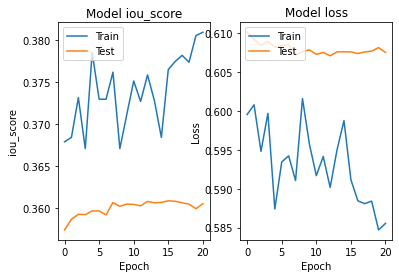

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

#### training continution 

In [ ]:
unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5') 

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.6014144420623779 | 0.6301812529563904 |  0.3660324215888977 | 0.34214308857917786 |
|   1   | 0.598611056804657  | 0.6231855154037476 | 0.36933356523513794 | 0.34876856207847595 |
|   2   | 0.5903542041778564 | 0.6254839897155762 |   0.37555992603302  |  0.349470317363739  |
|   3   | 0.5951789021492004 | 0.6281869411468506 |  0.3718777000904083 |  0.3462488055229187 |
|   4   | 0.608849048614502  | 0.6231335401535034 |  0.3608494699001312 |  0.349735826253891  |
|   5   | 0.5951998829841614 | 0.6211940050125122 |  0.3717927038669586 | 0.35114726424217224 |
|   6   | 0.5939581394195557 | 0.6161883473396301 | 0.37479668855667114 | 0.35436561703681946 |
|   7   | 0.6046388149261475 | 0.6191599

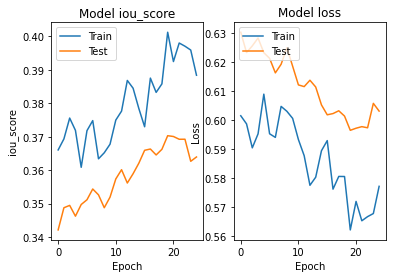

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

#### training continution 

In [ ]:
unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5') 

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.5642361044883728 | 0.5986746549606323 | 0.39852309226989746 | 0.36818379163742065 |
|   1   | 0.5747594237327576 | 0.6012461185455322 | 0.39000919461250305 | 0.36640065908432007 |
|   2   | 0.5689372420310974 | 0.5959738492965698 |  0.3951351046562195 |  0.3709249496459961 |
|   3   | 0.5567182898521423 | 0.5982118844985962 |  0.4065219759941101 |  0.3688928484916687 |
|   4   | 0.5726116299629211 | 0.5979592800140381 | 0.39193469285964966 | 0.36977192759513855 |
|   5   | 0.5631097555160522 | 0.5976860523223877 | 0.40071311593055725 |  0.3698658049106598 |
|   6   | 0.5595596432685852 | 0.6017987728118896 |  0.4039463698863983 |  0.3658638298511505 |
|   7   | 0.5601615309715271 | 0.5956727

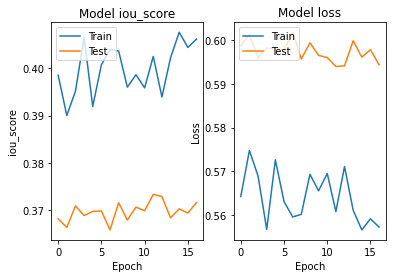

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

**Observation:** by training around 110 epochs, we could able to achieve better IOU scores for both training and test data. 

Till now we have used he base level efficient net ( B0 ), lets try to use moe complex efficientnet B4. 

### **Multilabel Classification model with efficient net B4 as back bone**

In [ ]:
class Unet_efficnetB8 :
  def __init__(self,input_shape,classes):
    tf.keras.backend.clear_session()
    self.input_shape = input_shape
    self.classes = classes
    self.inputs = Input(input_shape)
    self.encoder = EfficientNetB4(include_top=False, weights='imagenet', input_tensor= self.inputs)

  def conv_block(self,inputs,num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

  def decoder_block(self,inputs,skip, num_filters):
      x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
      x = Concatenate()([x, skip])
      x = self.conv_block(x, num_filters)
      return x

  def build_efficient_unet(self):
    
    s1 = self.encoder.get_layer("input_1").output  #skip connection 256X1600 

    s2 = self.encoder.get_layer("block2a_expand_activation").output  #skip connection 128X800

    s3 = self.encoder.get_layer("block3a_expand_activation").output  #skip connection 64X400

    s4 = self.encoder.get_layer("block4a_expand_activation").output  #skip connection 32X200

    s5 = self.encoder.get_layer("block6a_expand_activation").output  #skip connection 16X100

    """ Bottle neck"""

    b1 = self.encoder.get_layer("top_activation").output  # 8X50

    """decoder block"""
    d1 = self.decoder_block(b1,s5,512) #16 X 100 X 512 

    d2 = self.decoder_block(d1,s4,256) #32 X 200 X 256

    d3 = self.decoder_block(d2,s3,128) #64 X 400 X 128
  
    d4 = self.decoder_block(d3,s2,64) #128 X 800 X 64

    d5 = self.decoder_block(d4,s1,32) #256 X 1600 X 32

    """Output"""
    outputs = Conv2D(self.classes,1,padding = "same" , activation= "softmax")(d5) 
    
    unet_model = Model(self.inputs , outputs, name = "EfficientNetB4_UNET") 

    return  unet_model
if __name__ == "__main__" :
  input_shape  = (256,1600,3)
  ueff = Unet_efficnetB4(input_shape = input_shape,classes = 5 )
  unet_model = ueff.build_efficient_unet()
  unet_model.summary() 

71696384/71686520 [==============================] - 4s 0us/step
Model: "EfficientNetB4_UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1600, 3 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 1600, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 1600, 3) 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 1601, 3) 0           normalization[0][0]              
_______________

In [ ]:
# import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))

In [ ]:
ImageId= [ os.path.join(train_images_path,row.ImageId) for index,row in X_train.iterrows() ]
# MaskId= [ os.path.join(train_masks_path,row.ImageId) for index,row in X_train.iterrows() ]
X_train['ImageId'] = ImageId
# X_train['MaskId'] = MaskId

ImageId= [ os.path.join(train_images_path,row.ImageId) for index,row in X_test.iterrows() ]
# MaskId= [ os.path.join(train_masks_path,row.ImageId) for index,row in X_test.iterrows() ]
X_test['ImageId'] = ImageId
# X_test['MaskId'] = MaskId

In [ ]:
class Dataset:
    def __init__(self, data_df, preparation_for):
        
        self.images_fps   = data_df['ImageId'].values
        self.mask_fps     = data_df['numpy_masks'].values
        #preparation for = train or test
        self.preparation_for = preparation_for
        self.w = 256
        self.h = 1600
    
    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = load(self.mask_fps[i])

        if self.preparation_for == 'train':
          a = np.random.uniform()
          if a<0.2:
              image = aug2.augment_image(image)
              image_mask = aug2.augment_image(image_mask)
          elif a<0.4:
              image = aug3.augment_image(image)
              image_mask = aug3.augment_image(image_mask)
          elif a<0.6:
              image = aug4.augment_image(image)
              image_mask = aug4.augment_image(image_mask)
          elif a<0.8:
              image = aug5.augment_image(image)
              image_mask = image_mask 
        image = image.astype('float32')        
        image_mask = image_mask.astype('float32')                
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lrate = LearningRateScheduler(scheduler)  

es = tf.keras.callbacks.EarlyStopping( monitor='val_iou_score', patience= 15 , mode = 'max')

In [ ]:
callbacks = [ tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_iou_score') ,
                                       plot_losses ,lrate,es ] 

In [ ]:
# import keras
# Dataset for train images
train_dataset = Dataset(X_train, 'train')
test_dataset  = Dataset(X_test, 'test')

BATCH_SIZE= 4
train_dataloader = Dataloder(train_dataset, batch_size= BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size= BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
print(test_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)
print(test_dataloader[0][1].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE,256 , 1600, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 1600, 5)

(4, 256, 1600, 3)
(4, 256, 1600, 3)
(4, 256, 1600, 5)
(4, 256, 1600, 5)


#### Repeatition code when collab disconnects

In [ ]:
# unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5') 

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

#### Repeatition code when collab disconnects

In [ ]:
unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5') 

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.6554595828056335 | 0.6897014379501343 |  0.323646605014801  |  0.3066219687461853 |
|   1   | 0.6496402025222778 | 0.6543634533882141 |  0.328412264585495  | 0.32427647709846497 |
|   2   | 0.6523863673210144 | 0.6493929028511047 | 0.32634860277175903 | 0.32580751180648804 |
|   3   | 0.6523014903068542 | 0.6908957362174988 | 0.32666680216789246 | 0.29783257842063904 |
|   4   | 0.6487453579902649 | 0.6406847834587097 |  0.3286777436733246 | 0.33170148730278015 |
|   5   | 0.6422215700149536 | 0.6463807821273804 |  0.3336047828197479 | 0.33182621002197266 |
|   6   | 0.6501317620277405 | 0.6600557565689087 | 0.32788556814193726 |  0.3212665021419525 |
|   7   | 0.6486949324607849 | 0.6396342

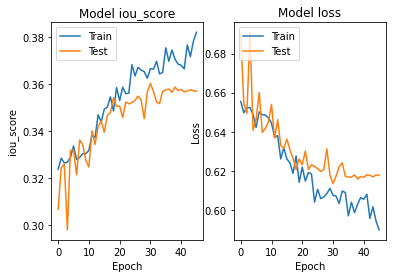

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

#### Repeatition code when collab disconnects

In [ ]:
unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5') 

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.5993257761001587 | 0.6165359616279602 | 0.37252095341682434 |  0.3575060963630676 |
|   1   | 0.5980167984962463 | 0.614068329334259  | 0.37470537424087524 | 0.35991138219833374 |
|   2   | 0.601525604724884  | 0.6234089732170105 | 0.37154635787010193 |  0.3518906831741333 |
|   3   | 0.6020379066467285 | 0.6202280521392822 | 0.37043309211730957 |  0.3554316461086273 |
|   4   | 0.6054922938346863 | 0.6185113191604614 |  0.3679836094379425 |  0.3555777966976166 |
|   5   | 0.608481228351593  | 0.6177065372467041 |  0.3657859265804291 |  0.3570575416088104 |
|   6   | 0.6051534414291382 | 0.6152143478393555 |  0.3677063286304474 |  0.3594834506511688 |
|   7   | 0.6066915988922119 | 0.6189666

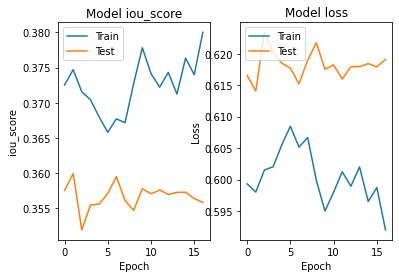

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

#### Repeatition code when collab disconnects

In [ ]:
unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5') 

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.6203101277351379 | 0.6373764872550964 | 0.35432034730911255 |  0.3401491940021515 |
|   1   |  0.6310995221138   | 0.6479343771934509 | 0.34452685713768005 |  0.3314420282840729 |
|   2   | 0.6261337995529175 | 0.6295864582061768 |  0.3488147556781769 | 0.34388160705566406 |
|   3   | 0.6317340135574341 | 0.629177987575531  | 0.34373849630355835 |  0.3447389006614685 |
|   4   | 0.6313602328300476 | 0.6380532383918762 |  0.3445632755756378 |  0.3382441997528076 |
|   5   | 0.6345648765563965 | 0.6404983401298523 | 0.34108778834342957 | 0.33769193291664124 |
|   6   | 0.6316429376602173 | 0.6330662369728088 | 0.34350094199180603 | 0.34411564469337463 |
|   7   | 0.6323794722557068 | 0.6466864

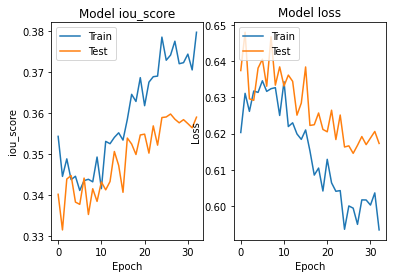

Epoch 34/500
 87/628 [===>..........................] - ETA: 7:47 - loss: 0.6008 - iou_score: 0.3729

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

**Observation:** We could not able to reach more than 0.38 IOU score for both train and test data. The model is still underfitting. Lets try efficientnet7 as the back bone 

### **Multilabel Classification model with efficient net B7 as back bone**

In [123]:
class Unet_efficnetB7 :
  def __init__(self,input_shape,classes):
    tf.keras.backend.clear_session()
    self.input_shape = input_shape
    self.classes = classes
    self.inputs = Input(input_shape)
    self.encoder = EfficientNetB7(include_top=False, weights='imagenet', input_tensor= self.inputs)

  def conv_block(self,inputs,num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

  def decoder_block(self,inputs,skip, num_filters):
      x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
      x = Concatenate()([x, skip])
      x = self.conv_block(x, num_filters)
      return x

  def build_efficient_unet(self):
    
    s1 = self.encoder.get_layer("input_1").output  #skip connection 256X1600 

    s2 = self.encoder.get_layer("block2a_expand_activation").output  #skip connection 128X800

    s3 = self.encoder.get_layer("block3a_expand_activation").output  #skip connection 64X400

    s4 = self.encoder.get_layer("block4a_expand_activation").output  #skip connection 32X200

    s5 = self.encoder.get_layer("block6a_expand_activation").output  #skip connection 16X100

    """ Bottle neck"""

    b1 = self.encoder.get_layer("top_activation").output  # 8X50

    """decoder block"""
    d1 = self.decoder_block(b1,s5,512) #16 X 100 X 512 

    d2 = self.decoder_block(d1,s4,256) #32 X 200 X 256

    d3 = self.decoder_block(d2,s3,128) #64 X 400 X 128
  
    d4 = self.decoder_block(d3,s2,64) #128 X 800 X 64

    d5 = self.decoder_block(d4,s1,32) #256 X 1600 X 32

    """Output"""
    outputs = Conv2D(self.classes,1,padding = "same" , activation= "softmax")(d5) 
    
    unet_model = Model(self.inputs , outputs, name = "EfficientNetB7_UNET") 

    return  unet_model

if __name__ == "__main__" :
  input_shape  = (256,1600,3)
  ueff = Unet_efficnetB7(input_shape = input_shape,classes = 5 )
  unet_model = ueff.build_efficient_unet()
  unet_model.summary()
  # model.get_layer("block6a_expand_activation") #16 X 100 X  

Model: "EfficientNetB4_UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1600, 3 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 1600, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 1600, 3) 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 1601, 3) 0           normalization[0][0]              
________________________________________________________________________________

In [38]:
# import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))

In [ ]:
ImageId= [ os.path.join(train_images_path,row.ImageId) for index,row in X_train.iterrows() ]
# MaskId= [ os.path.join(train_masks_path,row.ImageId) for index,row in X_train.iterrows() ]
X_train['ImageId'] = ImageId
# X_train['MaskId'] = MaskId

ImageId= [ os.path.join(train_images_path,row.ImageId) for index,row in X_test.iterrows() ]
# MaskId= [ os.path.join(train_masks_path,row.ImageId) for index,row in X_test.iterrows() ]
X_test['ImageId'] = ImageId
# X_test['MaskId'] = MaskId

In [36]:
class Dataset:
    def __init__(self, data_df, preparation_for):
        
        self.images_fps   = data_df['ImageId'].values
        self.mask_fps     = data_df['numpy_masks'].values
        #preparation for = train or test
        self.preparation_for = preparation_for
        self.w = 256
        self.h = 1600
    
    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = load(self.mask_fps[i])

        if self.preparation_for == 'train':
          a = np.random.uniform()
          if a<0.2:
              image = aug2.augment_image(image)
              image_mask = aug2.augment_image(image_mask)
          elif a<0.4:
              image = aug3.augment_image(image)
              image_mask = aug3.augment_image(image_mask)
          elif a<0.6:
              image = aug4.augment_image(image)
              image_mask = aug4.augment_image(image_mask)
          elif a<0.8:
              image = aug5.augment_image(image)
              image_mask = image_mask 
        image = image.astype('float32')        
        image_mask = image_mask.astype('float32')                
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [37]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lrate = LearningRateScheduler(scheduler)  

es = tf.keras.callbacks.EarlyStopping( monitor='val_iou_score', patience= 15 , mode = 'max')

In [38]:
callbacks = [ tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_iou_score') ,
                                       plot_losses ,lrate,es ] 

In [ ]:
# import keras
# Dataset for train images
train_dataset = Dataset(X_train, 'train')
test_dataset  = Dataset(X_test, 'test')

BATCH_SIZE= 2
train_dataloader = Dataloder(train_dataset, batch_size= BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size= BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
print(test_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)
print(test_dataloader[0][1].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE,256 , 1600, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 1600, 5)

(2, 256, 1600, 3)
(2, 256, 1600, 3)
(2, 256, 1600, 5)
(2, 256, 1600, 5)


#### Repeatition code when collab disconnects

In [ ]:
# unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5') 

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.7887513041496277 | 0.7535120248794556 | 0.22412721812725067 | 0.24687238037586212 |
|   1   | 0.755162239074707  | 0.7525341510772705 | 0.24739861488342285 | 0.24983662366867065 |
|   2   | 0.750157356262207  | 0.7636284232139587 | 0.25080183148384094 | 0.24217282235622406 |
|   3   | 0.7414623498916626 | 0.7585558891296387 | 0.25776857137680054 | 0.24625477194786072 |
|   4   | 0.7371208071708679 | 0.7356461882591248 |  0.2601170837879181 | 0.25913047790527344 |
|   5   | 0.7334260940551758 | 0.7440760135650635 |  0.2633121609687805 |  0.254264771938324  |
|   6   | 0.7280620336532593 | 0.7411287426948547 |  0.2674275040626526 |  0.2562927305698395 |
|   7   | 0.7231203317642212 | 0.7396481

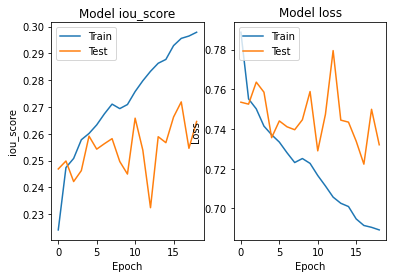

Epoch 20/500
  35/2513 [..............................] - ETA: 39:35 - loss: 0.6732 - iou_score: 0.3113

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

#### Repeatition code when collab disconnects

In [ ]:
unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5') 

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+---------------------+---------------------+
|   0   | 0.7006338834762573 | 0.7635795474052429 |  0.2883935570716858 | 0.24486702680587769 |
|   1   | 0.6975876092910767 | 0.7484266757965088 |  0.290711373090744  | 0.24997654557228088 |
|   2   | 0.6977044939994812 | 0.7362782955169678 |  0.2907451093196869 | 0.26073792576789856 |
|   3   | 0.6981656551361084 | 0.747677743434906  | 0.29098421335220337 | 0.25706154108047485 |
|   4   | 0.6948325037956238 | 0.7395554780960083 |  0.2932634949684143 |  0.265208899974823  |
|   5   | 0.6948181390762329 | 0.743767499923706  | 0.29300421476364136 | 0.25935110449790955 |
|   6   | 0.6943228244781494 | 0.7418164014816284 |  0.2929803729057312 |  0.2595253586769104 |
|   7   | 0.6954589486122131 | 0.7377682

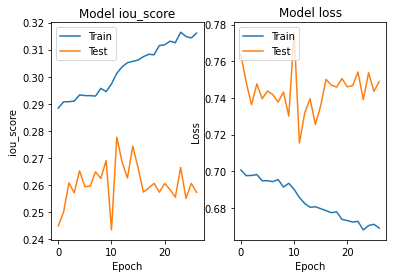

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

#### Repeatition code when collab disconnects

In [ ]:
unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5')  

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.RMSprop(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

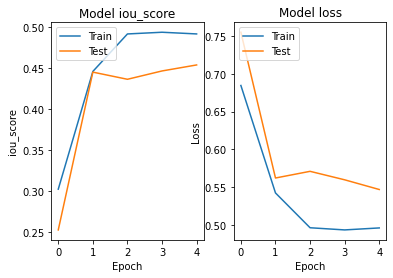

Epoch 6/500
2445/2513 [============================>.] - ETA: 1:16 - loss: 0.4967 - iou_score: 0.4916

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

**Observation:** After changing the optimizer to RMSprop from ADAM, the IOU score got increased from 0.24 to 0.44. Hence, lets train with RMSprop for few more epochs.

#### Repeatition code when collab disconnects

In [75]:
unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5') 

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.RMSprop(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+---------------------+--------------------+--------------------+---------------------+
| Epoch |         Loss        |      Val_Loss      |     Iou Scrore     |    Val_Iou Scrore   |
+-------+---------------------+--------------------+--------------------+---------------------+
|   0   |  0.4953587055206299 | 0.5735246539115906 | 0.4928642511367798 |  0.4425477087497711 |
|   1   |  0.4940653443336487 | 0.5596466660499573 | 0.4938218593597412 |  0.4493882358074188 |
|   2   |  0.4932093322277069 | 0.5316113233566284 | 0.4949442446231842 | 0.46702852845191956 |
|   3   | 0.49274805188179016 | 0.5670289993286133 | 0.4953875243663788 |  0.4399080276489258 |
|   4   | 0.49403098225593567 | 0.5514854192733765 | 0.4941592216491699 |  0.4519929885864258 |
+-------+---------------------+--------------------+--------------------+---------------------+


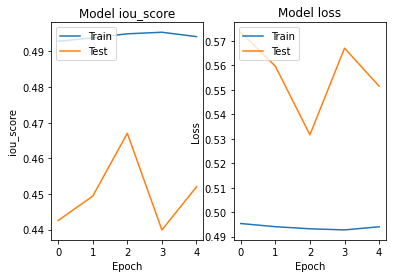

Epoch 6/500
1214/2513 [=============>................] - ETA: 23:27 - loss: 0.4939 - iou_score: 0.4944

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

**Observation:** There is no improvment in the IOUscore. Lets apply similar trick of chnaging the optimizer from RMSPROP to ADAM.

#### Repeatition code when collab disconnects

In [ ]:
unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5') 

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

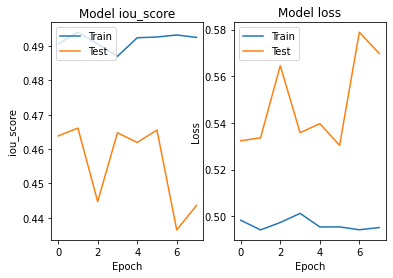

Epoch 9/500
 395/2513 [===>..........................] - ETA: 35:44 - loss: 0.4985 - iou_score: 0.4900

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

**Observation:** There is no improvment in the IOUscore. Lets apply similar trick of chnaging the optimizer from ADAM to SGD.

#### Repeatition code when collab disconnects

In [ ]:
unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5')  

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.SGD(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+---------------------+--------------------+---------------------+---------------------+
| Epoch |         Loss        |      Val_Loss      |      Iou Scrore     |    Val_Iou Scrore   |
+-------+---------------------+--------------------+---------------------+---------------------+
|   0   |  0.4966743290424347 | 0.5360081791877747 |  0.4922514855861664 | 0.46455392241477966 |
|   1   |  0.4931803345680237 | 0.5365762710571289 | 0.49477270245552063 | 0.46417391300201416 |
|   2   |  0.4941277503967285 | 0.532243549823761  |  0.4943121373653412 |  0.4667584300041199 |
|   3   | 0.49374186992645264 | 0.532431423664093  | 0.49440842866897583 | 0.46683287620544434 |
|   4   |  0.4924275577068329 | 0.5338491797447205 | 0.49566224217414856 | 0.46522095799446106 |
|   5   |  0.4938288629055023 | 0.536522626876831  |  0.4940882623195648 |  0.4639488756656647 |
+-------+---------------------+--------------------+---------------------+---------------------+


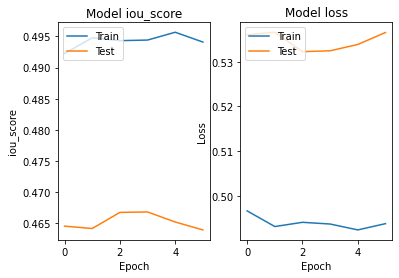

Epoch 7/500
1371/2513 [===============>..............] - ETA: 19:27 - loss: 0.4925 - iou_score: 0.4951

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

**Observation:** There is no improvment in the IOUscore. Lets increase the learning rate to 0.01

#### Repeatition code when collab disconnects

In [ ]:
unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5')  

In [ ]:
# https://github.com/qubvel/segmentation_models

# https://www.programmersought.com/article/34812621580/      to avoid common error of 'TFOptimizer' object has no attribute 'learning_rate'

optim = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss  
unet_model.compile(optim, focal_loss, metrics=[iou_score])

+-------+--------------------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |     Iou Scrore     |    Val_Iou Scrore   |
+-------+--------------------+--------------------+--------------------+---------------------+
|   0   | 0.4907103180885315 | 0.5531744360923767 | 0.4966127276420593 | 0.45282793045043945 |
+-------+--------------------+--------------------+--------------------+---------------------+


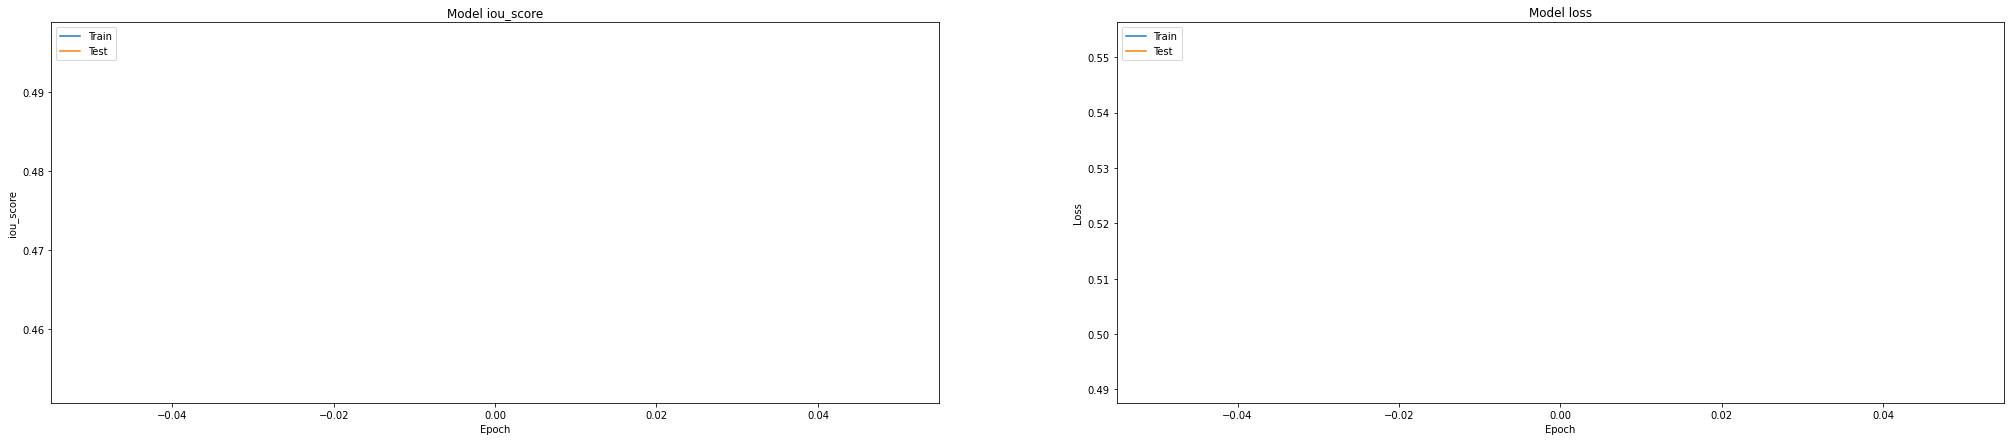

Epoch 2/500
 607/2513 [======>.......................] - ETA: 35:02 - loss: 0.4937 - iou_score: 0.4933

In [ ]:
unet_history = unet_model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//BATCH_SIZE ,epochs=500,\
                              validation_data = test_dataloader,callbacks=callbacks,\
                              validation_steps = len(test_dataloader)//BATCH_SIZE)

**Observation**: We can able to get only 0.45 test IoU score. Lets visualize the masks predicted by the model.

#### Comparing the masks predicted by the model and the original masks.

In [125]:
unet_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_multi_class_model.h5')  

Images and masks with out any defects


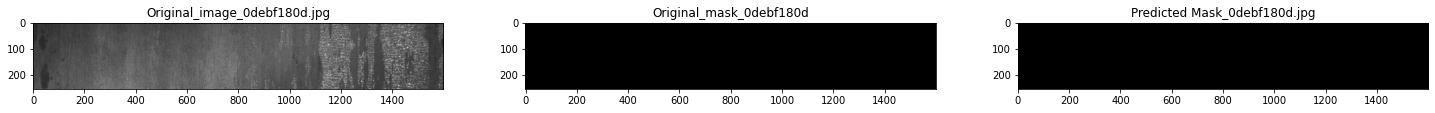

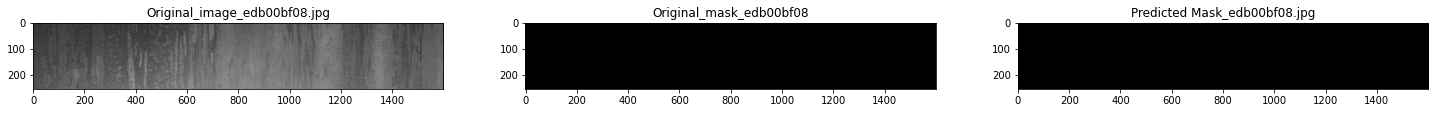

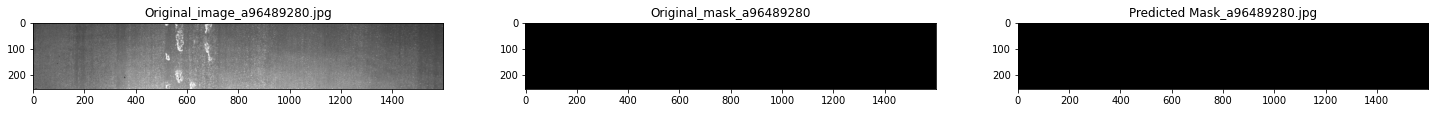

--------------------------------------------------------------------------------


In [126]:
# # Visualization: Sample original and predicted masks
print('Images and masks with out any defects')
cnt = 0
for i in X_test['ImageId'][X_test.hasDefect == 0 ].values :
  if cnt < 3:
    fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1,ncols = 3,figsize=(25, 6))
    img = cv2.imread(i)
    # pdb.set_trace()
    ax1.imshow(img)
    ax1.set_title('Original_image_'+os.path.split(i)[1])
    file_name = os.path.split(i)[1].split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X3
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    ax2.imshow(original_mask)
    ax2.set_title('Original_mask_'+os.path.split(file_name)[1].split('.')[0]) 
    
    img = cv2.imread( i)
    predict_mask = unet_model.predict(np.expand_dims(img, axis=0)).argmax(axis = -1) #256X1600X5 
    # pdb.set_trace() 
    predict_mask  = np.squeeze(predict_mask, axis=0)
    predict_mask  = one_frame_rgb(predict_mask,classes_tocolour)
    
    # predict_mask = width_height_classes_toRGB(predict_mask, classes_tocolour)
    ax3.imshow(predict_mask)
    ax3.set_title('Predicted Mask_'+os.path.split(i)[1])
    plt.show()
    cnt+=1 
  else :
    break
print('-'*80)   

Observation: the image has no defect and hence the predicted  image is completely black

Images and masks with type1 defects


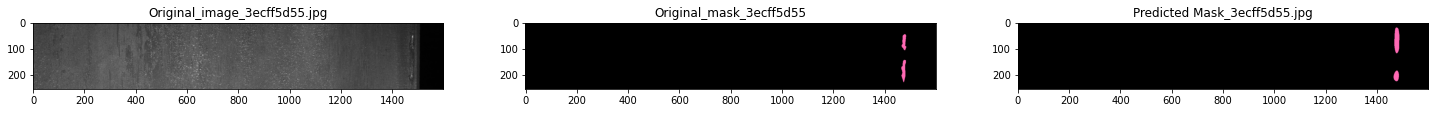

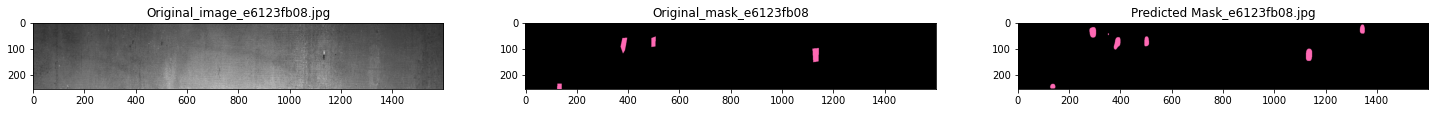

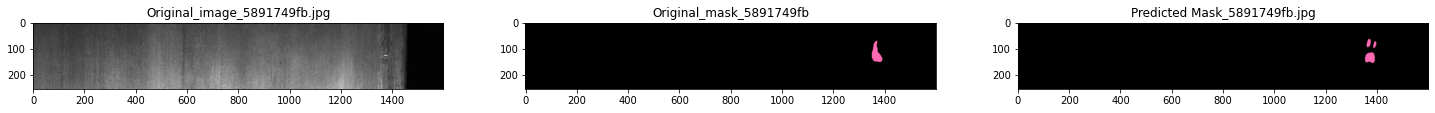

--------------------------------------------------------------------------------


In [127]:
# # Visualization: Sample original and predicted masks
print('Images and masks with type1 defects')
cnt = 0
for i in X_test['ImageId'][(X_test.hasDefect_1 == 1) & (X_test.hasDefect_2 == 0) & (X_test.hasDefect_3 == 0) & (X_test.hasDefect_4 == 0)].values :
  if cnt < 3:
    fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1,ncols = 3,figsize=(25, 6))
    img = cv2.imread(i)
    # pdb.set_trace()
    ax1.imshow(img)
    ax1.set_title('Original_image_'+os.path.split(i)[1])
    file_name = os.path.split(i)[1].split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X3
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    ax2.imshow(original_mask)
    ax2.set_title('Original_mask_'+os.path.split(file_name)[1].split('.')[0]) 
    
    img = cv2.imread( i)
    predict_mask = unet_model.predict(np.expand_dims(img, axis=0)).argmax(axis = -1) #256X1600X5 
    # pdb.set_trace() 
    predict_mask  = np.squeeze(predict_mask, axis=0)
    predict_mask  = one_frame_rgb(predict_mask,classes_tocolour)
    
    # predict_mask = width_height_classes_toRGB(predict_mask, classes_tocolour)
    ax3.imshow(predict_mask)
    ax3.set_title('Predicted Mask_'+os.path.split(i)[1])
    plt.show()
    cnt+=1 
  else :
    break
print('-'*80)   

**Observation**: We can observe that the model can able to predict most of the defect 1 spots.

Images and masks with type2 defects


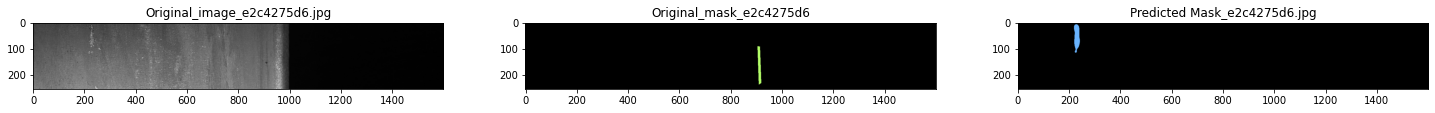

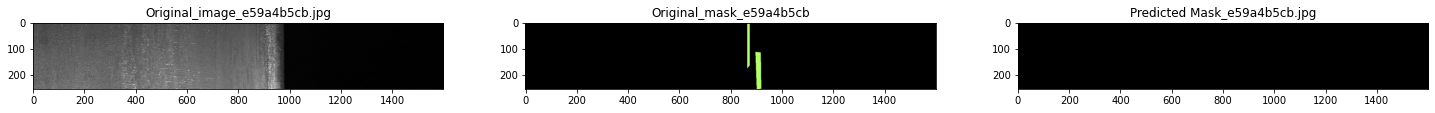

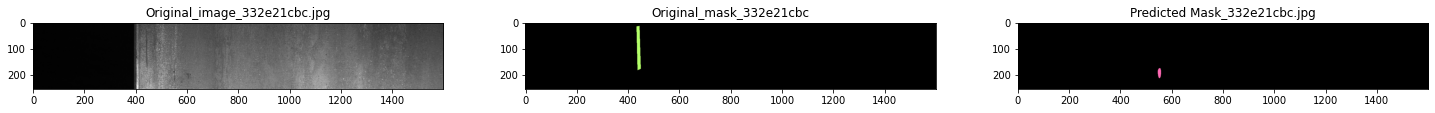

--------------------------------------------------------------------------------


In [128]:
# # Visualization: Sample original and predicted masks
print('Images and masks with type2 defects')
cnt = 0
for i in X_test['ImageId'][(X_test.hasDefect_1 == 0) & (X_test.hasDefect_2 == 1) & (X_test.hasDefect_3 == 0) & (X_test.hasDefect_4 == 0)].values :
  if cnt < 3:
    fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1,ncols = 3,figsize=(25, 6))
    img = cv2.imread(i)
    # pdb.set_trace()
    ax1.imshow(img)
    ax1.set_title('Original_image_'+os.path.split(i)[1])
    file_name = os.path.split(i)[1].split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X3
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    ax2.imshow(original_mask)
    ax2.set_title('Original_mask_'+os.path.split(file_name)[1].split('.')[0]) 
    
    img = cv2.imread( i)
    predict_mask = unet_model.predict(np.expand_dims(img, axis=0)).argmax(axis = -1) #256X1600X5 
    # pdb.set_trace() 
    predict_mask  = np.squeeze(predict_mask, axis=0)
    predict_mask  = one_frame_rgb(predict_mask,classes_tocolour)
    
    # predict_mask = width_height_classes_toRGB(predict_mask, classes_tocolour)
    ax3.imshow(predict_mask)
    ax3.set_title('Predicted Mask_'+os.path.split(i)[1])
    plt.show()
    cnt+=1 
  else :
    break
print('-'*80) 

**Observation:** Model is very much poor in detecting the type 2 defects. One reason can be data related to type 2 defects is very less. 

Images and masks with type3 defects


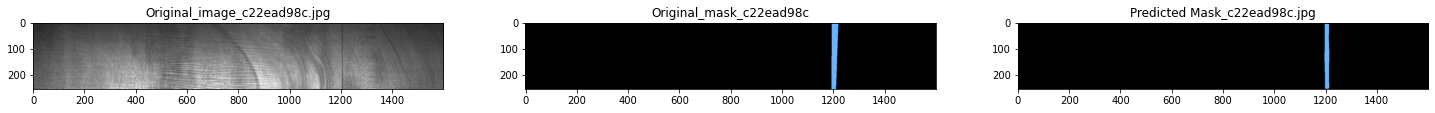

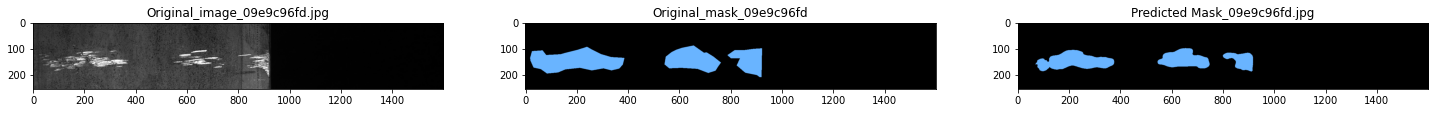

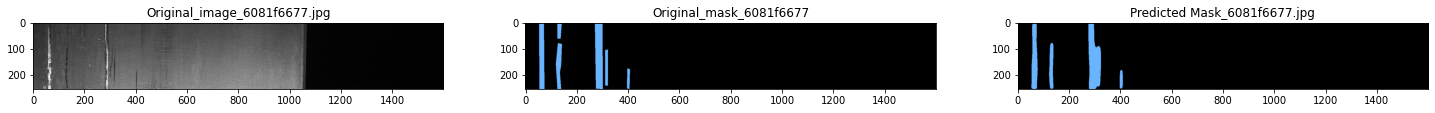

--------------------------------------------------------------------------------


In [129]:
# # Visualization: Sample original and predicted masks
print('Images and masks with type3 defects')
cnt = 0
for i in X_test['ImageId'][(X_test.hasDefect_1 == 0) & (X_test.hasDefect_2 == 0) & (X_test.hasDefect_3 == 1) & (X_test.hasDefect_4 == 0)].values :
  if cnt < 3:
    fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1,ncols = 3,figsize=(25, 6))
    img = cv2.imread(i)
    # pdb.set_trace()
    ax1.imshow(img)
    ax1.set_title('Original_image_'+os.path.split(i)[1])
    file_name = os.path.split(i)[1].split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X3
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    ax2.imshow(original_mask)
    ax2.set_title('Original_mask_'+os.path.split(file_name)[1].split('.')[0]) 
    
    img = cv2.imread( i)
    predict_mask = unet_model.predict(np.expand_dims(img, axis=0)).argmax(axis = -1) #256X1600X1 
    # pdb.set_trace() 
    predict_mask  = np.squeeze(predict_mask, axis=0)
    predict_mask  = one_frame_rgb(predict_mask,classes_tocolour)
    
    # predict_mask = width_height_classes_toRGB(predict_mask, classes_tocolour)
    ax3.imshow(predict_mask)
    ax3.set_title('Predicted Mask_'+os.path.split(i)[1])
    plt.show()
    cnt+=1 
  else :
    break
print('-'*80)  

**Observation:** model is very much capable of detecting the 3rd type defect aswell.

Images and masks with type4 defects


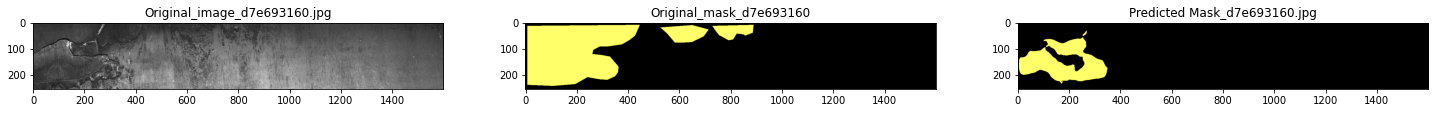

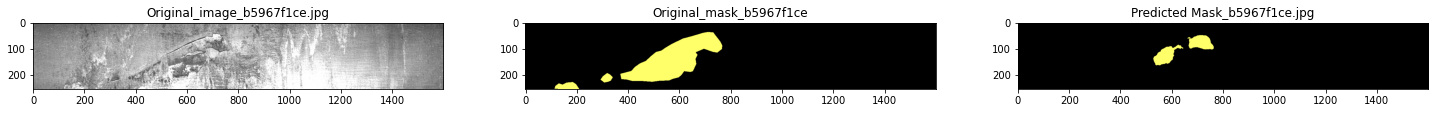

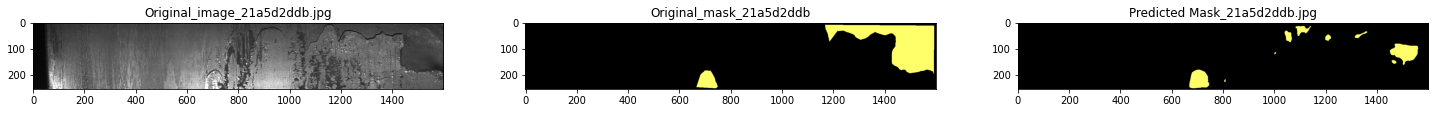

--------------------------------------------------------------------------------


In [130]:
# # Visualization: Sample original and predicted masks
print('Images and masks with type4 defects')
cnt = 0
for i in X_test['ImageId'][(X_test.hasDefect_1 == 0) & (X_test.hasDefect_2 == 0) & (X_test.hasDefect_3 == 0) & (X_test.hasDefect_4 == 1)].values :
  if cnt < 3:
    fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1,ncols = 3,figsize=(25, 6))
    img = cv2.imread(i)
    # pdb.set_trace()
    ax1.imshow(img)
    ax1.set_title('Original_image_'+os.path.split(i)[1])
    file_name = os.path.split(i)[1].split('.')[0] + '.npy'
    original_mask = np.load(os.path.join(train_masks_npy_path, file_name)) #256 X 1600X3
    original_mask = width_height_classes_toRGB(original_mask, classes_tocolour)
    ax2.imshow(original_mask)
    ax2.set_title('Original_mask_'+os.path.split(file_name)[1].split('.')[0]) 
    
    img = cv2.imread( i)
    predict_mask = unet_model.predict(np.expand_dims(img, axis=0)).argmax(axis = -1) #256X1600X5 
    # pdb.set_trace() 
    predict_mask  = np.squeeze(predict_mask, axis=0)
    predict_mask  = one_frame_rgb(predict_mask,classes_tocolour)
    
    # predict_mask = width_height_classes_toRGB(predict_mask, classes_tocolour)
    ax3.imshow(predict_mask)
    ax3.set_title('Predicted Mask_'+os.path.split(i)[1])
    plt.show()
    cnt+=1 
  else :
    break
print('-'*80)   

**Observation:** Above plots show that, the model prediction order is as below 
defect3 > defect 1 > defect4 > defect2 

and this order order is same as the distribution of defects in the given data.

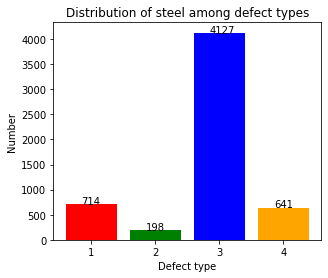

### confusion matrix for the predictions made by multilabel classefier on test data.

In [131]:
X_test_actual  = X_test[['hasDefect','hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']].to_numpy()
X_test_predict = []
for i in X_test['ImageId'].values:
  X_test_predict_i = []
  img = cv2.imread(i)
  predict_mask = unet_model.predict(np.expand_dims(img, axis=0)).argmax(axis = -1) #256X1600X5 
  predict_mask  = np.squeeze(predict_mask, axis=0)
  hasDefect = 0 
  hasDefect_1 = 0
  hasDefect_2 = 0
  hasDefect_3 = 0 
  hasDefect_4 = 0 
  if ( predict_mask == 1 ).sum()  :
    hasDefect = 1 
    hasDefect_1 = 1

  if ( predict_mask == 2 ).sum()  :
    hasDefect = 1 
    hasDefect_2 = 1

  if ( predict_mask == 3 ).sum() :
    hasDefect = 1 
    hasDefect_3 = 1

  if ( predict_mask == 4 ).sum() :
    hasDefect = 1 
    hasDefect_4 = 1
  X_test_predict_i = [hasDefect,hasDefect_1,hasDefect_2,hasDefect_3,hasDefect_4]
  X_test_predict.append(X_test_predict_i)

X_test_predict = np.array(X_test_predict)

In [140]:
target_names = ['hasDefect','hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']

Confusion , Precision and recall matrices for hasDefect


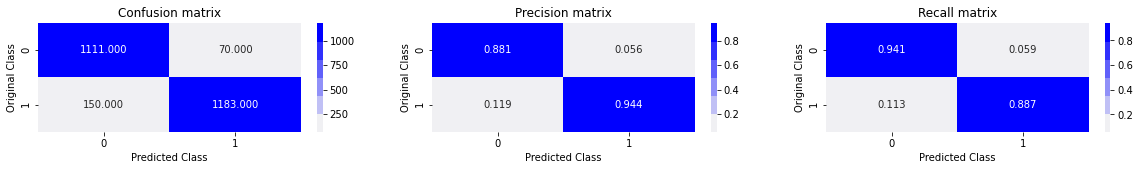

Confusion , Precision and recall matrices for hasDefect_1


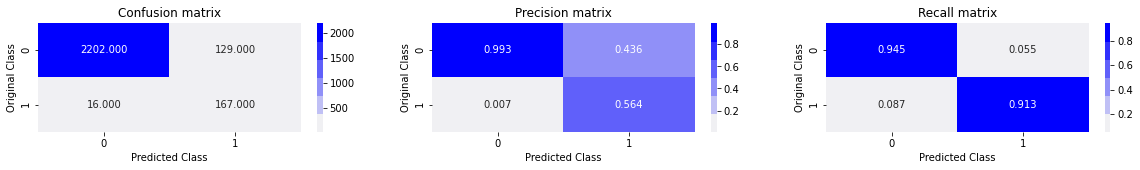

Confusion , Precision and recall matrices for hasDefect_2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


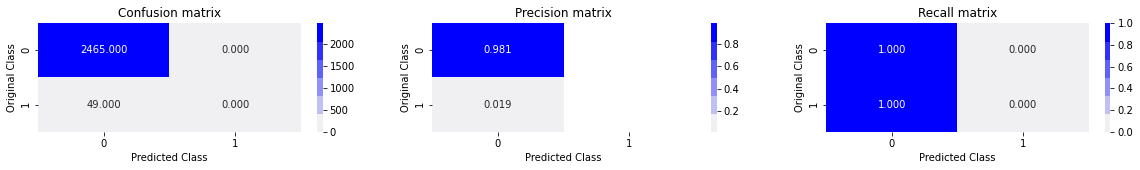

Confusion , Precision and recall matrices for hasDefect_3


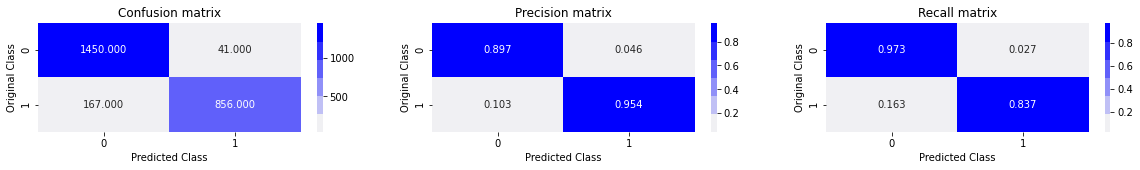

Confusion , Precision and recall matrices for hasDefect_4


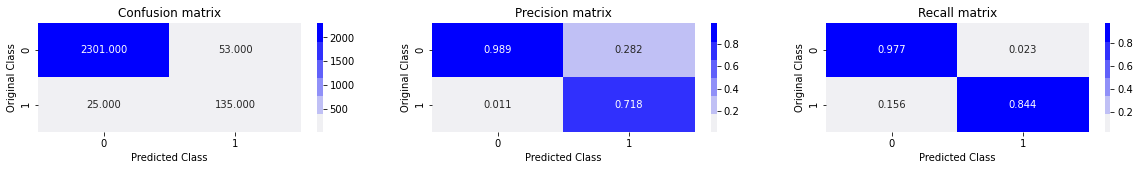

In [149]:
plot_confusion_matrix(X_test_actual,X_test_predict,target_names)

**Observation:**  We can observe that except for type  2 defects every other defect type has good scores.

### Binary Classification

**Observation** We already have unet to detect the defects. But on seeing the data given there are equal number of images which has no defect as well. In such a case we can develop another algorithm to classify steel images which has defect and which doesnt has defect. For this we can use the encoder which we have trained in the above Unet and we can add few more top layers.

In [63]:
#Binary Classification model
tf.keras.backend.clear_session()
binary_model = Sequential()
binary_model.add(Input(shape=(256, 1600, 3)))
binary_model.add(ueff.encoder) #8, 50, 2560
for layer in binary_model.layers:
    layer.trainable = False
binary_model.add(Flatten()) 

binary_model.add(Dense(512, activation='relu'))
binary_model.add(BatchNormalization(name = 'BN0'))
binary_model.add(Dropout(0.3))

# binary_model.add(Dense(512, activation='relu'))
# binary_model.add(BatchNormalization(name = 'BN1'))
# binary_model.add(Dropout(0.3))

binary_model.add(Dense(64, activation='relu'))
binary_model.add(BatchNormalization(name = 'BN1'))
binary_model.add(Dropout(0.3))

binary_model.add(Dense(32, activation='relu'))
binary_model.add(BatchNormalization(name = 'BN2'))
binary_model.add(Dropout(0.3))

# binary_model.add(Dense(64, activation='relu'))
# binary_model.add(BatchNormalization(name = 'BN3'))
# binary_model.add(Dropout(0.3))

# binary_model.add(Dense(32, activation='relu'))
# binary_model.add(BatchNormalization(name = 'BN3'))
# binary_model.add(Dropout(0.3))

binary_model.add(Dense(16, activation='relu'))
binary_model.add(BatchNormalization(name = 'BN3'))
binary_model.add(Dropout(0.3))

binary_model.add(Dense(1, activation='sigmoid'))
binary_model.build(ueff.encoder.input_shape) 
binary_model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 8, 50, 2560)       64097687  
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 512)               524288512 
_________________________________________________________________
BN0 (BatchNormalization)     (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 64)                32832     
_________________________________________________________________
BN1 (BatchNormalization)     (None, 64)                2

In [ ]:
X_train['ImageId'] = [os.path.split(i)[1]  for i in X_train['ImageId'].values ]
X_test['ImageId'] = [os.path.split(i)[1]  for i in X_test['ImageId'].values ]

In [64]:
# https://keras.io/preprocessing/image/
# https://stackoverflow.com/questions/52754492/write-custom-data-generator-for-keras

# DataGenerator for the binary classification model with image augmentations

train_DataGenerator_1 = ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.05, rotation_range=5,
                           width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)

test_DataGenerator_1 = ImageDataGenerator(rescale=1./255)

train_generator = train_DataGenerator_1.flow_from_dataframe(
        dataframe= X_train.astype(str),
        directory=train_images_path,
        x_col="ImageId",
        y_col="hasDefect",
        target_size=(256,1600),
        batch_size= 32,
        class_mode='binary')

validation_generator = test_DataGenerator_1.flow_from_dataframe(
        dataframe=X_test.astype(str),
        directory=train_images_path,
        x_col="ImageId",
        y_col="hasDefect",
        target_size=(256,1600),
        batch_size= 32,
        class_mode='binary')

Found 10054 validated image filenames belonging to 2 classes.
Found 2514 validated image filenames belonging to 2 classes.


In [65]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lrate = LearningRateScheduler(scheduler)  

es = tf.keras.callbacks.EarlyStopping( monitor='val_accuracy', patience= 5 , mode = 'max')

In [66]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/severstal-steel-defect-detection/best_binary_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy') ,
                                       plot_binary_losses ,lrate,es]

#### Reatition block of code 

+-------+--------------------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |      Val_Loss      |      accuracy      |     Val_accuracy    |
+-------+--------------------+--------------------+--------------------+---------------------+
|   0   | 0.7194558382034302 | 0.701786458492279  | 0.5099621415138245 |  0.4697452187538147 |
|   1   | 0.7005155086517334 | 0.6927257776260376 |  0.51225346326828  |  0.5306528806686401 |
|   2   | 0.6963860988616943 | 0.6960824131965637 | 0.5158398151397705 |  0.5306528806686401 |
|   3   | 0.6926128268241882 | 0.6997725963592529 | 0.5283921360969543 |  0.4697452187538147 |
|   4   | 0.6923569440841675 | 0.6920920014381409 | 0.5276947617530823 |  0.5302547812461853 |
|   5   | 0.6918620467185974 | 0.6912669539451599 | 0.5291891098022461 |  0.5306528806686401 |
|   6   | 0.6918627619743347 | 0.6913929581642151 | 0.5296871662139893 |  0.5302547812461853 |
|   7   | 0.6916495561599731 | 0.7542670965194702 

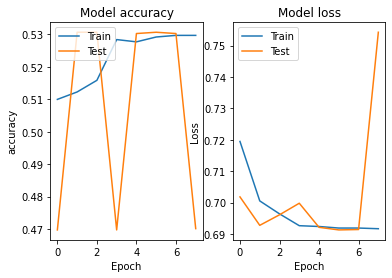

Epoch 9/40
236/628 [==========>...................] - ETA: 9:32 - loss: 0.6918 - accuracy: 0.5307

In [ ]:
binary_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])


effinet_history = binary_model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = X_train.shape[0]//16, 
                                epochs = 40, verbose = 1 , callbacks = callbacks,
                                validation_steps = X_test.shape[0]//16)

**Observation:** We can observe that the validation accuracy is not being increased from 0.53. Lets change the optimizer to RMSPROP from ADAM.

#### Reatition block of code 

In [67]:
binary_model.load_weights('/content/drive/MyDrive/severstal-steel-defect-detection/best_binary_model.h5')

+-------+--------------------+--------------------+--------------------+--------------------+
| Epoch |        Loss        |      Val_Loss      |      accuracy      |    Val_accuracy    |
+-------+--------------------+--------------------+--------------------+--------------------+
|   0   | 0.6968742609024048 | 0.865692138671875  | 0.5184299945831299 | 0.4697452187538147 |
|   1   | 0.6926421523094177 | 0.742461085319519  | 0.5292887091636658 | 0.5302547812461853 |
|   2   | 0.6920821070671082 | 0.6936731934547424 | 0.5292887091636658 | 0.5306528806686401 |
|   3   | 0.6921191811561584 | 0.691307783126831  | 0.5282924771308899 | 0.5302547812461853 |
|   4   | 0.6917499899864197 | 0.6913869380950928 | 0.5279936194419861 | 0.5302547812461853 |
+-------+--------------------+--------------------+--------------------+--------------------+


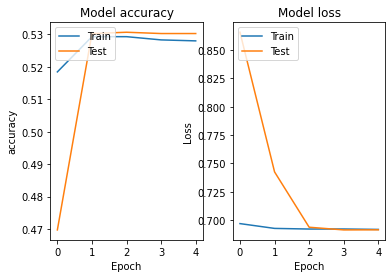

Epoch 6/40
 48/628 [=>............................] - ETA: 14:09 - loss: 0.6922 - accuracy: 0.5247

In [ ]:
binary_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
effinet_history = binary_model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = X_train.shape[0]//16, 
                                epochs = 40, verbose = 1 , callbacks = callbacks,
                                validation_steps = X_test.shape[0]//16)

**Observation:** We can observe that the validation accuracy is still not being increased from 0.53. Lets increase the learning rate to 0.01 RMSPROP from ADAM.

#### Repeatition block of code 

+-------+--------------------+--------------------+--------------------+--------------------+
| Epoch |        Loss        |      Val_Loss      |      accuracy      |    Val_accuracy    |
+-------+--------------------+--------------------+--------------------+--------------------+
|   0   | 0.7234240174293518 | 0.697037398815155  | 0.5036918520927429 | 0.5300480723381042 |
|   1   | 0.7040588855743408 | 0.6949231624603271 | 0.5055876970291138 |      0.46875       |
|   2   | 0.6945721507072449 | 0.6912744641304016 | 0.5189582705497742 | 0.5308493375778198 |
|   3   | 0.6932085156440735 | 0.6914688348770142 | 0.520854115486145  | 0.5292468070983887 |
|   4   | 0.6926897168159485 | 0.691594660282135  | 0.5222510695457458 | 0.5288461446762085 |
|   5   | 0.692509114742279  | 0.6912922859191895 | 0.5245460271835327 | 0.5304487347602844 |
|   6   | 0.6919357776641846 | 0.6913739442825317 | 0.5299341678619385 | 0.5300480723381042 |
+-------+--------------------+--------------------+---------

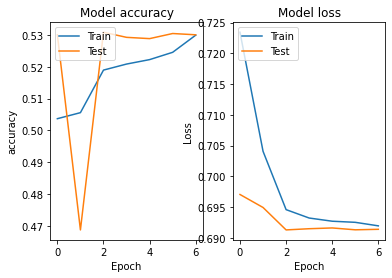

Epoch 8/40
  8/314 [..............................] - ETA: 14:23 - loss: 0.6847 - accuracy: 0.5664

In [ ]:
binary_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])
effinet_history = binary_model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = X_train.shape[0]//32, 
                                epochs = 40, verbose = 1 , callbacks = callbacks,
                                validation_steps = X_test.shape[0]//32)

**Observation:** **The accuracy is not getting increased from 0.53. Hence, we will just use the multi class classifier. bold text** 